## Import Library

In [68]:
import pandas as pd
import sqlite3
from bs4 import BeautifulSoup
import requests
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from supabase.client import create_client
import os
from dotenv import load_dotenv
import boto3
from firebase_admin import credentials, initialize_app
from firebase_admin import storage
import random
import string

## 2. Extract Data

In [3]:
# electricity_access_percent.csv
ds1 = pd.read_csv('./dataset/electricity_access_percent.csv')

# gdp_data.csv
ds2 = pd.read_csv('./dataset/gdp_data.csv')

# mystery.csv
# ds3 = pd.read_csv('./dataset/mystery.csv')

# population_data.csv
ds4 = pd.read_csv('./dataset/population_data.csv')

# population_data.json
ds5 = pd.read_json('./dataset/population_data.json')

# population_data.xml
with open('./dataset/population_data.xml', 'r') as file:
    ds6 = BeautifulSoup(file, 'lxml')

# projects_data.csv
ds7 = pd.read_csv('./dataset/projects_data.csv')

# rural_population_percent.csv
ds8 = pd.read_csv('./dataset/rural_population_percent.csv')

# api from https://api.worldbank.org/v2/countries/id;sg;my;sa/indicators/SP.POP.TOTL/?format=json&per_page=1000
apiDs9 = requests.get('http://api.worldbank.org/v2/countries/br;cn;us;id/indicators/SP.POP.TOTL/?format=json&per_page=1000')
ds9 = apiDs9.json()

# population_data.db
conn = sqlite3.connect('./dataset/population_data.db')
cursor = conn.cursor()
cursor.execute("""SELECT * FROM population_data""")
ds10 = cursor.fetchall()

C:\Users\muham\AppData\Local\Temp\ipykernel_27996\2133344711.py:21: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  ds7 = pd.read_csv('./dataset/projects_data.csv')


## 3. Transformasi Data

### 3.1 Mengolah data API menjadi dataframe

In [4]:
# ds9 = population_data API

# Mengambil data yang diperlukan
ds9_data = ds9[1]

# Membuat DataFrame dari data
custom_columns = ['Indicator Name', 'Indicator Code', 'Country Name', 'Country Code', 'Year', 'Value']

# Membuat DataFrame dengan kolom yang disesuaikan
ds9 = pd.DataFrame(columns=custom_columns)

# Mengisi DataFrame dengan data yang sesuai
for entry in ds9_data:
    indicator_name = entry['indicator']['value']
    indicator_code = entry['indicator']['id']
    country_name = entry['country']['value']
    country_code = entry['countryiso3code']
    date = entry['date']
    value = entry['value']
    
    ds9.loc[len(ds9)] = [indicator_name, indicator_code, country_name, country_code, date, value]

# Menampilkan DataFrame
ds9

,Indicator Name,Indicator Code,Country Name,Country Code,Year,Value
0,"Population, total",SP.POP.TOTL,Brazil,BRA,2023,None
1,"Population, total",SP.POP.TOTL,Brazil,BRA,2022,215313498
2,"Population, total",SP.POP.TOTL,Brazil,BRA,2021,214326223
3,"Population, total",SP.POP.TOTL,Brazil,BRA,2020,213196304
4,"Population, total",SP.POP.TOTL,Brazil,BRA,2019,211782878
...,...,...,...,...,...,...
251,"Population, total",SP.POP.TOTL,United States,USA,1964,191889000
252,"Population, total",SP.POP.TOTL,United States,USA,1963,189242000
253,"Population, total",SP.POP.TOTL,United States,USA,1962,186538000
254,"Population, total",SP.POP.TOTL,United States,USA,1961,183691000


In [5]:
# ds4 = population_data csv
ds4

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [6]:
# ds5 = population_data json
ds5

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [7]:
# ds6 = population_data xml
data=[]
for record in ds6.find_all("record"):
    record_data = {}
    for field in record.find_all("field"):
        name = field.get("name")
        value = field.text
        record_data[name] = value
    data.append(record_data)

ds6 = pd.DataFrame(data)

new_kolom = {
    'Item': 'Indicator Name',
    'Country or Area': 'Country Name',
}

# Mengganti nama kolom
ds6 = ds6.rename(columns=new_kolom)
ds6

,Country Name,Indicator Name,Year,Value
0,Aruba,"Population, total",1960,54211
1,Aruba,"Population, total",1961,55438
2,Aruba,"Population, total",1962,56225
3,Aruba,"Population, total",1963,56695
4,Aruba,"Population, total",1964,57032
...,...,...,...,...
15307,Zimbabwe,"Population, total",2013,15054506
15308,Zimbabwe,"Population, total",2014,15411675
15309,Zimbabwe,"Population, total",2015,15777451
15310,Zimbabwe,"Population, total",2016,16150362


In [8]:
# ds10 = population_data db

ds10 = pd.DataFrame(ds10)

# kolom awal 0,1,2,3,4,...dst
# drop kolom "0"
ds10.drop(columns=0,inplace=True)

# mengambil kolom ds4 untuk direplace ke kolom ds10
ds4_columns = ds4.columns
ds10.columns = ds4_columns
ds10

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


### 3.2 Combine Data population_data csv, json, xml, api, dan db

In [9]:
# Menghapus karakter spesial terlebih dahulu untuk kolom yang akan digabungkan (Country Name)
ds4['Country Name'] = ds4['Country Name'].replace(to_replace=r'[^a-zA-Z\s\&\-\(\),.:]', value='', regex=True)
ds5['Country Name'] = ds5['Country Name'].replace(to_replace=r'[^a-zA-Z\s\&\-\(\),.:]', value='', regex=True)
ds10['Country Name'] = ds10['Country Name'].replace(to_replace=r'[^a-zA-Z\s\&\-\(\),.:]', value='', regex=True)

# Menggabungkan ds4 dengan ds5 tanpa menggabungkan kolom
combined_ds4_ds5 = ds4.copy()
combined_ds4_ds5.update(ds5)

# Menggabungkan hasil penggabungan dengan ds10 tanpa menggabungkan kolom
combined_ds = combined_ds4_ds5.copy()
combined_ds.update(ds10)

combined_ds['Country Name'] = combined_ds['Country Name'].replace(to_replace=r'[^a-zA-Z\s\&\-\(\),.:]', value='', regex=True)
combined_ds.drop(combined_ds[combined_ds['Country Name'] == 'Not classified'].index, inplace=True)
combined_ds


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [10]:
# Melakukan pivot pada DataFrame dengan pivot_table
ds6['Value'] = pd.to_numeric(ds6['Value'])
ds6 = ds6.pivot_table(index=['Country Name', 'Indicator Name'], columns='Year', values='Value', sort=False).reset_index()

# Mengubah nama indeks kolom 'Year' menjadi string
ds6.columns.name = None
ds6['Country Name'] = ds6['Country Name'].replace(to_replace=r'[^a-zA-Z\s\&\-\(\),.:]', value='', regex=True)

ds6


,Country Name,Indicator Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,"Population, total",54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,"Population, total",8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,"Population, total",5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,"Population, total",1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,"Population, total",13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Kosovo,"Population, total",947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
259,"Yemen, Rep.","Population, total",5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,5748588.0,5858638.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
260,South Africa,"Population, total",17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,20486439.0,21045785.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
261,Zambia,"Population, total",3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,3676189.0,3791887.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [11]:
# Combine hasil penggabungan ds4, ds5, ds10 (combined_ds) dengan ds6
combined_ds = combined_ds.copy()
combined_ds.update(ds6.set_index('Country Name'))
# ds6.update(combined_ds.set_index('Country Name'))
# combined_ds = ds6.copy()
combined_ds


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [12]:
ds9['Value'] = pd.to_numeric(ds9['Value'])
ds9 = ds9.pivot_table(index=['Country Name','Country Code', 'Indicator Name', 'Indicator Code'], columns='Year', values='Value', sort=True).reset_index()

# Mengubah nama indeks kolom 'Year' menjadi string
ds9.columns.name = None
ds9

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Brazil,BRA,"Population, total",SP.POP.TOTL,73092515.0,75330008.0,77599218.0,79915555.0,82262794.0,84623747.0,...,2.017218e+08,2.034596e+08,2.051882e+08,2.068596e+08,2.085050e+08,2.101666e+08,2.117829e+08,2.131963e+08,2.143262e+08,2.153135e+08
1,China,CHN,"Population, total",SP.POP.TOTL,667070000.0,660330000.0,665770000.0,682335000.0,698355000.0,715185000.0,...,1.363240e+09,1.371860e+09,1.379860e+09,1.387790e+09,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09,1.412175e+09
2,Indonesia,IDN,"Population, total",SP.POP.TOTL,88382881.0,90816938.0,93345489.0,95962527.0,98675061.0,101157868.0,...,2.532759e+08,2.562298e+08,2.590920e+08,2.618502e+08,2.644989e+08,2.670668e+08,2.695829e+08,2.718580e+08,2.737532e+08,2.755013e+08
3,United States,USA,"Population, total",SP.POP.TOTL,180671000.0,183691000.0,186538000.0,189242000.0,191889000.0,194303000.0,...,3.160599e+08,3.183863e+08,3.207390e+08,3.230718e+08,3.251221e+08,3.268382e+08,3.283300e+08,3.315115e+08,3.320316e+08,3.332876e+08


In [13]:
# Combine hasil penggabungan ds4, ds5, ds10,ds6 (combined_ds) dengan ds9
combined_ds = combined_ds.copy()
# combined_ds.update(ds9.set_index('Country Name'))
# Ambil daftar negara dari ds9
countries = ds9['Country Name'].unique()

# Loop melalui setiap negara
for country in countries:
    # Ambil indeks baris yang memiliki 'Country Name' sesuai dengan negara yang dipilih
    index = combined_ds.index[combined_ds['Country Name'] == country]
    
    # Jika negara tersebut ada di combined_ds
    if len(index) > 0:
        # Loop melalui setiap tahun
        for year in range(1960, 2018):
            # Ambil nilai dari dataset ds9 untuk negara dan tahun yang dipilih
            new_value = ds9.loc[ds9['Country Name'] == country, str(year)].values[0]
        
            # Ganti nilai di combined_ds dengan nilai baru
            combined_ds.loc[index, str(year)] = new_value

combined_ds

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


### 3.3 Kombinasikan data dari rural_population_percent.csv dan electricity_access_percent.csv yang merupakan data populasi pedesaan dan akses listrik dari berbagai negara. dan kemudian gabungkan menggunakan pandas. (jangan lupa melakukan penyesuaian terhadap dataset ini, cek missing values, duplikasi data, dan lain-lain)

In [14]:
# ds8 = rural, ds1 = electricity
comb = pd.merge(ds8,ds1,on=['Country Name','Country Code'],suffixes=('_rural_population_percent', '_electricity_access_percent'))
comb

,Country Name,Country Code,Indicator Name_rural_population_percent,Indicator Code_rural_population_percent,1960_rural_population_percent,1961_rural_population_percent,1962_rural_population_percent,1963_rural_population_percent,1964_rural_population_percent,1965_rural_population_percent,...,2008_electricity_access_percent,2009_electricity_access_percent,2010_electricity_access_percent,2011_electricity_access_percent,2012_electricity_access_percent,2013_electricity_access_percent,2014_electricity_access_percent,2015_electricity_access_percent,2016_electricity_access_percent,2017_electricity_access_percent
0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,49.300,...,93.086166,93.354546,93.356292,93.942375,94.255814,94.578262,94.906723,95.238182,95.570145,NaN
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,90.250,...,42.400000,44.854885,42.700000,43.222019,69.100000,67.259552,89.500000,71.500000,84.137138,NaN
2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,87.496,...,31.268013,32.382469,33.514950,34.600000,35.821964,36.990490,32.000000,42.000000,40.520607,NaN
3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,68.770,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN
4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,29.555,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,Rural population (% of total population),SP.RUR.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,97.794670,98.377060,0.000000,99.430435,99.773651,99.942505,99.993134,100.000000,100.000000,NaN
260,"Yemen, Rep.",YEM,Rural population (% of total population),SP.RUR.TOTL.ZS,90.900,90.541,90.169,89.784,89.386,88.974,...,60.386539,61.751400,63.134281,64.532181,65.942101,75.600000,66.100000,70.213905,71.642349,NaN
261,South Africa,ZAF,Rural population (% of total population),SP.RUR.TOTL.ZS,53.381,53.207,53.094,52.980,52.866,52.752,...,81.900000,82.700000,82.900000,84.700000,85.300000,85.400000,86.000000,85.500000,84.200000,NaN
262,Zambia,ZMB,Rural population (% of total population),SP.RUR.TOTL.ZS,81.855,81.049,80.215,79.288,77.985,76.628,...,22.714685,23.235649,22.000000,24.328644,24.894667,25.469702,27.900000,31.100000,27.219337,NaN


#### 3.3.1 Penyesuaian Type Data

In [15]:
print("Type Data Sebelumnya : ")
comb.dtypes

Type Data Sebelumnya : 


Country Name                                object
Country Code                                object
Indicator Name_rural_population_percent     object
Indicator Code_rural_population_percent     object
1960_rural_population_percent              float64
                                            ...   
2013_electricity_access_percent            float64
2014_electricity_access_percent            float64
2015_electricity_access_percent            float64
2016_electricity_access_percent            float64
2017_electricity_access_percent            float64
Length: 122, dtype: object

In [16]:
print("Type Data Setelahnya : ")
comb.dtypes
# tidak ada perubahan tipe data karena tipe data sudah sesuai

Type Data Setelahnya : 


Country Name                                object
Country Code                                object
Indicator Name_rural_population_percent     object
Indicator Code_rural_population_percent     object
1960_rural_population_percent              float64
                                            ...   
2013_electricity_access_percent            float64
2014_electricity_access_percent            float64
2015_electricity_access_percent            float64
2016_electricity_access_percent            float64
2017_electricity_access_percent            float64
Length: 122, dtype: object

#### 3.3.2 Handling Missing Value dan Duplicates

In [17]:
# HANDLING MISSING VALUE DENGAN MENGISI NULL dengan 0
comb = comb.fillna(0)

# DROP / HAPUS DATA DUPLICATES
comb = comb.drop_duplicates()

#DROP KOLOM TIDAK DIGUNAKAN (Not Classified)
comb.drop(comb[comb['Country Name'] == 'Not classified'].index, inplace=True)

# MENGHAPUS KARAKTER TERTENTU
comb['Country Name'] = comb['Country Name'].replace(to_replace=r'[^a-zA-Z\s\'\&\-\(\),.:]', value='', regex=True)

comb

,Country Name,Country Code,Indicator Name_rural_population_percent,Indicator Code_rural_population_percent,1960_rural_population_percent,1961_rural_population_percent,1962_rural_population_percent,1963_rural_population_percent,1964_rural_population_percent,1965_rural_population_percent,...,2008_electricity_access_percent,2009_electricity_access_percent,2010_electricity_access_percent,2011_electricity_access_percent,2012_electricity_access_percent,2013_electricity_access_percent,2014_electricity_access_percent,2015_electricity_access_percent,2016_electricity_access_percent,2017_electricity_access_percent
0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,49.300,...,93.086166,93.354546,93.356292,93.942375,94.255814,94.578262,94.906723,95.238182,95.570145,0.0
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,90.250,...,42.400000,44.854885,42.700000,43.222019,69.100000,67.259552,89.500000,71.500000,84.137138,0.0
2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,87.496,...,31.268013,32.382469,33.514950,34.600000,35.821964,36.990490,32.000000,42.000000,40.520607,0.0
3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,68.770,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.0
4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,29.555,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,Rural population (% of total population),SP.RUR.TOTL.ZS,0.000,0.000,0.000,0.000,0.000,0.000,...,97.794670,98.377060,0.000000,99.430435,99.773651,99.942505,99.993134,100.000000,100.000000,0.0
260,"Yemen, Rep.",YEM,Rural population (% of total population),SP.RUR.TOTL.ZS,90.900,90.541,90.169,89.784,89.386,88.974,...,60.386539,61.751400,63.134281,64.532181,65.942101,75.600000,66.100000,70.213905,71.642349,0.0
261,South Africa,ZAF,Rural population (% of total population),SP.RUR.TOTL.ZS,53.381,53.207,53.094,52.980,52.866,52.752,...,81.900000,82.700000,82.900000,84.700000,85.300000,85.400000,86.000000,85.500000,84.200000,0.0
262,Zambia,ZMB,Rural population (% of total population),SP.RUR.TOTL.ZS,81.855,81.049,80.215,79.288,77.985,76.628,...,22.714685,23.235649,22.000000,24.328644,24.894667,25.469702,27.900000,31.100000,27.219337,0.0


### 3.4 Cleaning Data population_data.csv, population_data.json, population_data.xml, dan population_data.db. lakukan penyesuaian terhadap dataset ini, cek missing values, duplikasi data, dan lain-lain.

#### 3.4.1 Hasil Gabungan dari population_data csv, json, xml, db, dan api

##### 3.4.1.1 Penyesuaian tipe data

In [18]:
print("Tipe data sebelumnya : ")
combined_ds.info()

Tipe data sebelumnya : 
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    263 non-null    object 
 1   Country Code    263 non-null    object 
 2   Indicator Name  263 non-null    object 
 3   Indicator Code  263 non-null    object 
 4   1960            260 non-null    float64
 5   1961            260 non-null    float64
 6   1962            260 non-null    float64
 7   1963            260 non-null    float64
 8   1964            260 non-null    float64
 9   1965            260 non-null    float64
 10  1966            260 non-null    float64
 11  1967            260 non-null    float64
 12  1968            260 non-null    float64
 13  1969            260 non-null    float64
 14  1970            260 non-null    float64
 15  1971            260 non-null    float64
 16  1972            260 non-null    float64
 17  1973            

In [19]:
print("Tipe data setelahnya : ")
combined_ds.info()
# tidak ada perubahan tipe data karena tipe data sudah sesuai

Tipe data setelahnya : 
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    263 non-null    object 
 1   Country Code    263 non-null    object 
 2   Indicator Name  263 non-null    object 
 3   Indicator Code  263 non-null    object 
 4   1960            260 non-null    float64
 5   1961            260 non-null    float64
 6   1962            260 non-null    float64
 7   1963            260 non-null    float64
 8   1964            260 non-null    float64
 9   1965            260 non-null    float64
 10  1966            260 non-null    float64
 11  1967            260 non-null    float64
 12  1968            260 non-null    float64
 13  1969            260 non-null    float64
 14  1970            260 non-null    float64
 15  1971            260 non-null    float64
 16  1972            260 non-null    float64
 17  1973            

##### 3.4.1.2 Handling Missing Value dan Duplicates

In [20]:
# KEADAAN SEBELUMNYA
print("BEFORE : ")
combined_ds

BEFORE : 


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [21]:
# KEADAAN SETELAHNYA
combined_ds = combined_ds.drop_duplicates()
combined_ds = combined_ds.fillna(0)
print("AFTER : ")
combined_ds

AFTER : 


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


### 3.5 Penyesuaian tipe data untuk dataset projects_data.csv, population_data.csv, population_data.json, population_data.xml, dan population_data.db. misalnya yang sesuai dengan tipe data datetime, float, integer, string, dan lain-lain. bisa menggunakn to_numeric, to_datetime, dan lain-lain.

#### 3.5.1 projects_data.csv

In [22]:
# MENGHAPUS TANDA ; DI KOLOM countryname
ds7['countryname'] = ds7['countryname'].apply(lambda x: x.split(';')[-1])

# MENGHAPUS KARAKTER ","
ds7['lendprojectcost'] = ds7['lendprojectcost'].str.replace(',','')
ds7['ibrdcommamt'] = ds7['ibrdcommamt'].str.replace(',','')
ds7['idacommamt'] = ds7['idacommamt'].str.replace(',','')
ds7['totalamt'] = ds7['totalamt'].str.replace(',','')
ds7['grantamt'] = ds7['grantamt'].str.replace(',','')

# MENGHAPUS KARAKTER SELAIN NUMERIK / HURUF
ds7['sector1'] = ds7['sector1'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['sector2'] = ds7['sector2'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['sector3'] = ds7['sector3'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['sector4'] = ds7['sector4'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['sector5'] = ds7['sector5'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['theme1'] = ds7['theme1'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['theme2'] = ds7['theme2'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['theme3'] = ds7['theme3'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['theme4'] = ds7['theme4'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['theme5'] = ds7['theme5'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)
ds7['location'] = ds7['location'].replace(to_replace=r'[^a-zA-Z]', value='', regex=True)

ds7

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,lendinginstrtype.1,supplementprojectflg,productlinetype,projectstatusdisplay,...,mjtheme2name,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country
0,P162228,Other,World,RE,Investment Project Financing,IN,C,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P163962,Africa,Democratic Republic of the Congo,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P167672,South Asia,People's Republic of Bangladesh,PE,Investment Project Financing,IN,NaN,Y,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P158768,South Asia,Islamic Republic of Afghanistan,PE,Investment Project Financing,IN,A,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P161364,Africa,Federal Republic of Nigeria,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,OgunStateNGNigerStateNGAbiaStateNGEdoNGKebbiSt...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,P006578,Latin America and Caribbean,Republic of Chile,PE,Specific Investment Loan,IN,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18244,P037451,Europe and Central Asia,Grand Duchy of Luxembourg,PE,Structural Adjustment Loan,AD,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18245,P037362,Europe and Central Asia,Kingdom of Denmark,PE,Structural Adjustment Loan,AD,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18246,P037452,Europe and Central Asia,Kingdom of the Netherlands,PE,Structural Adjustment Loan,AD,NaN,N,L,Closed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 3.5.1.1 Penyesuaian Tipe Data

In [23]:
print("Tipe data sebelumnya : ")
ds7.info()

Tipe data sebelumnya : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 56 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    18248 non-null  object 
 1   regionname            18248 non-null  object 
 2   countryname           18248 non-null  object 
 3   prodline              18248 non-null  object 
 4   lendinginstr          18002 non-null  object 
 5   lendinginstrtype      18002 non-null  object 
 6   lendinginstrtype.1    12437 non-null  object 
 7   supplementprojectflg  18195 non-null  object 
 8   productlinetype       18248 non-null  object 
 9   projectstatusdisplay  18244 non-null  object 
 10  status                18244 non-null  object 
 11  project_name          18248 non-null  object 
 12  boardapprovaldate     16744 non-null  object 
 13  board_approval_month  16744 non-null  object 
 14  closingdate           14899 non-null  object 


In [24]:
# MENGUBAH TIPE DATA
ds7['lendprojectcost'] = pd.to_numeric(ds7['lendprojectcost'])
ds7['ibrdcommamt'] = pd.to_numeric(ds7['ibrdcommamt'])
ds7['idacommamt'] = pd.to_numeric(ds7['idacommamt'])
ds7['totalamt'] = pd.to_numeric(ds7['totalamt'])
ds7['grantamt'] = pd.to_numeric(ds7['grantamt'])
ds7['boardapprovaldate'] = pd.to_datetime(ds7['boardapprovaldate'])
ds7['closingdate'] = pd.to_datetime(ds7['closingdate'])

In [25]:
print("Tipe data setelahnya : ")
ds7.info()

Tipe data setelahnya : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 56 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   id                    18248 non-null  object             
 1   regionname            18248 non-null  object             
 2   countryname           18248 non-null  object             
 3   prodline              18248 non-null  object             
 4   lendinginstr          18002 non-null  object             
 5   lendinginstrtype      18002 non-null  object             
 6   lendinginstrtype.1    12437 non-null  object             
 7   supplementprojectflg  18195 non-null  object             
 8   productlinetype       18248 non-null  object             
 9   projectstatusdisplay  18244 non-null  object             
 10  status                18244 non-null  object             
 11  project_name          18248 non-null  objec

##### 3.5.1.2 Drop kolom dan handling missing value

In [26]:
# MENGHAPUS / DROP KOLOM YANG TIDAK DIGUNAKAN ATAU NULL LEBIH DARI 50%

# ds7.drop(columns=['projectdoc ','majorsector_percent ','mjsector1','mjsector2','mjsector3','mjsector4','mjsector5','theme ','mjtheme1name','mjtheme2name',
#                  'mjtheme3name','mjtheme4name','mjtheme5name','Unnamed: 56'], inplace=True)
null_counts = ds7.isnull().sum()

# Tentukan kolom mana yang memiliki lebih dari 50% nilai null
columns_to_drop = null_counts[null_counts > 0.5 * len(ds7)].index
print(columns_to_drop)

# Drop kolom-kolom yang memenuhi kriteria tersebut
ds7.drop(columns=columns_to_drop, inplace=True)



# MENGHAPUS / DROP KOLOM YANG MEMILIKI VALUE 0 LEBIH DARI 50%

# Hitung jumlah nilai 0 di setiap kolom
zero_counts = (ds7 == 0).sum()

# Tentukan kolom mana yang memiliki lebih dari 50% nilai 0
columns_to_drop = zero_counts[zero_counts > 0.5 * len(ds7)].index

# Drop kolom-kolom yang memenuhi kriteria tersebut
ds7.drop(columns=columns_to_drop, inplace=True)

# Mengisi value 0 pada kolom numerik dengan mean / rata-rata
for col in ds7.columns:
    # Cek apakah kolom merupakan kolom numerik
    if pd.api.types.is_numeric_dtype(ds7[col]):
        # Ambil mean dari kolom tersebut
        mean_value = ds7[col].mean()
        # Ganti nilai null atau 0 dengan mean
        ds7[col] = ds7[col].replace(0, mean_value)

# Drop value null
ds7 = ds7.dropna()

ds7

Index(['projectdoc ', 'majorsector_percent ', 'sector3', 'sector4', 'sector5',
       'mjsector1', 'mjsector2', 'mjsector3', 'mjsector4', 'mjsector5',
       'theme3', 'theme4', 'theme5', 'theme ', 'financier', 'mjtheme1name',
       'mjtheme2name', 'mjtheme3name', 'mjtheme4name', 'mjtheme5name',
       'location', 'GeoLocID', 'GeoLocName', 'Latitude', 'Longitude',
       'Country'],
      dtype='object')


,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,lendinginstrtype.1,supplementprojectflg,productlinetype,projectstatusdisplay,...,borrower,impagency,url,sector1,sector2,sector,mjsector,theme1,theme2,goal
37,P154525,South Asia,Republic of India,PE,Investment Project Financing,IN,B,N,L,Active,...,EPATET,IIST,http://projects.worldbank.org/P154525?lang=en,WorkforceDevelopmentandVocationalEducationEW,PublicAdministrationEducationEF,Workforce Development and Vocational Education...,Education;Education;Education,Exportdevelopmentandcompetitiveness,Educationfortheknowledgeeconomy,Corporate Advocacy Priorities|Global Public Go...
64,P158713,East Asia and Pacific,People's Republic of China,PE,Investment Project Financing,IN,B,N,L,Active,...,PEPLES,LIAI U,http://projects.worldbank.org/P158713?lang=en,WaterSupplyWC,PublicAdministrationWaterSanitationandWasteMan...,Water Supply;Water Supply;Public Administratio...,Water; Sanitation and Waste Management;Water; ...,Climatechange,Waterresourcemanagement,Global Public Goods Priorities|Millennium Deve...
144,P157809,Middle East and North Africa,Arab Republic of Egypt,PE,Investment Project Financing,IN,C,N,L,Active,...,EET,IIST,http://projects.worldbank.org/P157809?lang=en,PrimaryEducationEP,PublicAdministrationEducationEF,Primary Education;Primary Education;Public Adm...,Education;Education;Education;Education;Education,Educationfortheknowledgeeconomy,Otherpublicsectorgovernance,Corporate Advocacy Priorities|Global Public Go...
182,P156894,South Asia,Islamic Republic of Afghanistan,PE,Investment Project Financing,IN,B,N,L,Active,...,ISLAIC E,IIST,http://projects.worldbank.org/P156894?lang=en,ICTInfrastructureCI,ICTServicesCS,ICT Infrastructure;ICT Infrastructure;ICT Serv...,Information and Communications Technologies;In...,Regionalintegration,Infrastructureservicesforprivatesectordevelopment,Global Public Goods Priorities|Millennium Deve...
183,P157206,Africa,Republic of Cote d'Ivoire,PE,Investment Project Financing,IN,A,N,L,Active,...,IIST,IIST,http://projects.worldbank.org/P157206?lang=en,OtherAgricultureFishingandForestryAZ,PublicAdministrationAgricultureFishingForestryAK,Other Agriculture; Fishing and Forestry;Other ...,Agriculture; Fishing and Forestry;Agriculture;...,Landadministrationandmanagement,Otherpublicsectorgovernance,Global Public Goods Priorities|Millennium Deve...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12463,P010252,South Asia,Islamic Republic of Pakistan,PE,Specific Investment Loan,IN,C,N,L,Closed,...,GOVERNMENT OF PAKISTAN,MIN. OF LABOR; MANPOWER AND OVERSEAS PAKISTANIS,http://projects.worldbank.org/P010252/vocation...,VocationaltrainingEV,CentralGovernmentCentralAgenciesBC,Vocational training;Vocational training;Centra...,Education;Education;Public Administration;Publ...,Improvinglabormarkets,Gender,Corporate Advocacy Priorities;Corporate Advoca...
12468,P005818,Middle East and North Africa,Republic of Yemen,PE,Sector Investment and Maintenance Loan,IN,C,N,L,Closed,...,GOVERNMENT,TIHAMA DEVELOPMENT AUTHORITY,http://projects.worldbank.org/P005818/tihama-r...,IrrigationandDrainageAI,OtherPublicAdministrationBZ,Irrigation and Drainage;Irrigation and Drainag...,Agriculture; Fishing and Forestry;Agriculture;...,Waterresourcemanagement,Ruralmarkets,Global Public Goods Priorities|Millennium Deve...
12474,P007633,Latin America and Caribbean,United Mexican States,PE,Specific Investment Loan,IN,C,N,L,Closed,...,NAFINSA,SARH,http://projects.worldbank.org/P007633/tropical...,IrrigationandDrainageAI,OtherTransportationTZ,Irrigation and Drainage;Irrigation and Drainag...,Agriculture; Fishing and Forestry;Agriculture;...,Otherruraldevelopment,Improvinglabormarkets,Corporate Advocacy Priorities;Corporate Advoca...
12512,P005945,Latin America and Caribbean,Argentine Republic,PE,Specific Investment Loan,IN,C,N,L,Closed,...,GOVERNMENT,EPOS; OSN; DIPOS,http://projects.worldbank.org/P005945/water-su...,WaterSupplyWC,SewerageWS,Wat

In [27]:
# MENGHILANGKAN VALUE YANG DUPLIKAT DI KOLOM SECTOR, MJSECTOR, DAN GOAL
# DENGAN CARA VALUE DIPISAHKAN DAN DIJADIKAN SET, KARENA SET BERSIFAT UNIK. LALU DIGABUNGKAN KEMBALI

ds7['sector'] = ds7['sector'].apply(lambda x: ';'.join(set(x.split(';'))))
ds7['mjsector'] = ds7['mjsector'].apply(lambda x: ';'.join(set(x.split(';'))))
ds7['goal'] = ds7['goal'].apply(lambda x: ';'.join(set(x.split(';'))))

ds7

C:\Users\muham\AppData\Local\Temp\ipykernel_27996\1118704948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds7['sector'] = ds7['sector'].apply(lambda x: ';'.join(set(x.split(';'))))
C:\Users\muham\AppData\Local\Temp\ipykernel_27996\1118704948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds7['mjsector'] = ds7['mjsector'].apply(lambda x: ';'.join(set(x.split(';'))))
C:\Users\muham\AppData\Local\Temp\ipykernel_27996\1118704948.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,lendinginstrtype.1,supplementprojectflg,productlinetype,projectstatusdisplay,...,borrower,impagency,url,sector1,sector2,sector,mjsector,theme1,theme2,goal
37,P154525,South Asia,Republic of India,PE,Investment Project Financing,IN,B,N,L,Active,...,EPATET,IIST,http://projects.worldbank.org/P154525?lang=en,WorkforceDevelopmentandVocationalEducationEW,PublicAdministrationEducationEF,Public Administration - Education;Workforce De...,Education,Exportdevelopmentandcompetitiveness,Educationfortheknowledgeeconomy,CAP|GPG|GPG|MDG;CAP;Corporate Advocacy Priorit...
64,P158713,East Asia and Pacific,People's Republic of China,PE,Investment Project Financing,IN,B,N,L,Active,...,PEPLES,LIAI U,http://projects.worldbank.org/P158713?lang=en,WaterSupplyWC,PublicAdministrationWaterSanitationandWasteMan...,Water Supply; Sanitation and Waste Management;...,Sanitation and Waste Management;Water,Climatechange,Waterresourcemanagement,GPG|MDG;Global Public Goods Priorities|Millenn...
144,P157809,Middle East and North Africa,Arab Republic of Egypt,PE,Investment Project Financing,IN,C,N,L,Active,...,EET,IIST,http://projects.worldbank.org/P157809?lang=en,PrimaryEducationEP,PublicAdministrationEducationEF,Public Administration - Education;Early Childh...,Education,Educationfortheknowledgeeconomy,Otherpublicsectorgovernance,Corporate Advocacy Priorities|Global Public Go...
182,P156894,South Asia,Islamic Republic of Afghanistan,PE,Investment Project Financing,IN,B,N,L,Active,...,ISLAIC E,IIST,http://projects.worldbank.org/P156894?lang=en,ICTInfrastructureCI,ICTServicesCS,ICT Services;ICT Infrastructure;Public Adminis...,Information and Communications Technologies,Regionalintegration,Infrastructureservicesforprivatesectordevelopment,Corporate Advocacy Priorities;GPG|MDG;Global P...
183,P157206,Africa,Republic of Cote d'Ivoire,PE,Investment Project Financing,IN,A,N,L,Active,...,IIST,IIST,http://projects.worldbank.org/P157206?lang=en,OtherAgricultureFishingandForestryAZ,PublicAdministrationAgricultureFishingForestryAK,Public Administration - Agriculture;Other Agri...,Agriculture; Fishing and Forestry,Landadministrationandmanagement,Otherpublicsectorgovernance,Corporate Advocacy Priorities;GPG|MDG;Global P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12463,P010252,South Asia,Islamic Republic of Pakistan,PE,Specific Investment Loan,IN,C,N,L,Closed,...,GOVERNMENT OF PAKISTAN,MIN. OF LABOR; MANPOWER AND OVERSEAS PAKISTANIS,http://projects.worldbank.org/P010252/vocation...,VocationaltrainingEV,CentralGovernmentCentralAgenciesBC,Vocational training;Sub-National Government;Ce...,Public Administration;Education,Improvinglabormarkets,Gender,CAP|MDG;CAP;CAP|GPG;Corporate Advocacy Priorit...
12468,P005818,Middle East and North Africa,Republic of Yemen,PE,Sector Investment and Maintenance Loan,IN,C,N,L,Closed,...,GOVERNMENT,TIHAMA DEVELOPMENT AUTHORITY,http://projects.worldbank.org/P005818/tihama-r...,IrrigationandDrainageAI,OtherPublicAdministrationBZ,Research;Other Public Administration;Agricult...,Agriculture;Public Administration; Fishing and...,Waterresourcemanagement,Ruralmarkets,Corporate Advocacy Priorities;GPG|MDG;Global P...
12474,P007633,Latin America and Caribbean,United Mexican States,PE,Specific Investment Loan,IN,C,N,L,Closed,...,NAFINSA,SARH,http://projects.worldbank.org/P007633/tropical...,IrrigationandDrainageAI,OtherTransportationTZ,Fishing and Forestry; Research;Central Govern...,Agriculture;Public Administration;Transportati...,Otherruraldevelopment,Improvinglabormarkets,Corporate Advocacy Priorities;GPG|MDG;Global P...
12512,P005945,Latin America and Caribbean,Argentine Republic,PE,Specific Investment Loan,IN,C,N,L,Closed,...,GOVERNMENT,EPOS; OSN; DIPOS,http://projects.worldbank.org/P005945/water-su...,WaterSupplyWC,SewerageWS,Water Supply;Central Government (Central Agenc...,Sanitation and Waste Management;Public Admini...,Pollutionmanagemen

#### 3.5.2 Hasil Gabungan dari population_data csv, json, xml, db, dan api (combined_ds)

##### 3.5.2.1 Penyesuaian tipe data

In [28]:
print("Tipe data sebelumnya : ")
combined_ds.info()

Tipe data sebelumnya : 
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    263 non-null    object 
 1   Country Code    263 non-null    object 
 2   Indicator Name  263 non-null    object 
 3   Indicator Code  263 non-null    object 
 4   1960            263 non-null    float64
 5   1961            263 non-null    float64
 6   1962            263 non-null    float64
 7   1963            263 non-null    float64
 8   1964            263 non-null    float64
 9   1965            263 non-null    float64
 10  1966            263 non-null    float64
 11  1967            263 non-null    float64
 12  1968            263 non-null    float64
 13  1969            263 non-null    float64
 14  1970            263 non-null    float64
 15  1971            263 non-null    float64
 16  1972            263 non-null    float64
 17  1973            

In [29]:
print("Tipe data setelahnya : ")
combined_ds.info()
# tidak ada perubahan tipe data karena tipe data sudah sesuai

Tipe data setelahnya : 
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    263 non-null    object 
 1   Country Code    263 non-null    object 
 2   Indicator Name  263 non-null    object 
 3   Indicator Code  263 non-null    object 
 4   1960            263 non-null    float64
 5   1961            263 non-null    float64
 6   1962            263 non-null    float64
 7   1963            263 non-null    float64
 8   1964            263 non-null    float64
 9   1965            263 non-null    float64
 10  1966            263 non-null    float64
 11  1967            263 non-null    float64
 12  1968            263 non-null    float64
 13  1969            263 non-null    float64
 14  1970            263 non-null    float64
 15  1971            263 non-null    float64
 16  1972            263 non-null    float64
 17  1973            

### 3.6 Encoding dataset mystery.csv yang memiliki encoding berbeda. gunakan encoding='utf-16' untuk membaca dataset ini

In [30]:
ds3 = pd.read_csv('./dataset/mystery.csv', encoding='utf-16')
ds3

,Unnamed: 0,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


#### 3.6.1 Cleaning Dataset

##### 3.6.1.1 Penyesuaian Tipe Data

In [31]:
print("Tipe data sebelumnya : ")
ds3.info()

Tipe data sebelumnya : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      264 non-null    int64  
 1   Country Name    264 non-null    object 
 2   Country Code    264 non-null    object 
 3   Indicator Name  264 non-null    object 
 4   Indicator Code  264 non-null    object 
 5   1960            260 non-null    float64
 6   1961            260 non-null    float64
 7   1962            260 non-null    float64
 8   1963            260 non-null    float64
 9   1964            260 non-null    float64
 10  1965            260 non-null    float64
 11  1966            260 non-null    float64
 12  1967            260 non-null    float64
 13  1968            260 non-null    float64
 14  1969            260 non-null    float64
 15  1970            260 non-null    float64
 16  1971            260 non-null    float64
 17  1972       

In [32]:
print("Tipe data setelahnya : ")
ds3.info()

# tidak ada perubahan tipe data karena tipe data sudah sesuai

Tipe data setelahnya : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      264 non-null    int64  
 1   Country Name    264 non-null    object 
 2   Country Code    264 non-null    object 
 3   Indicator Name  264 non-null    object 
 4   Indicator Code  264 non-null    object 
 5   1960            260 non-null    float64
 6   1961            260 non-null    float64
 7   1962            260 non-null    float64
 8   1963            260 non-null    float64
 9   1964            260 non-null    float64
 10  1965            260 non-null    float64
 11  1966            260 non-null    float64
 12  1967            260 non-null    float64
 13  1968            260 non-null    float64
 14  1969            260 non-null    float64
 15  1970            260 non-null    float64
 16  1971            260 non-null    float64
 17  1972       

##### 3.6.1.2 Gabungkan dengan rural dan electricity

In [33]:
# dataset mystery.csv sama persis seperti population_data. Inisiatif untuk menggabungkan dengan rural dan electricity untuk analisis lainnya
ds3.drop(ds3[ds3['Country Name'] == 'Not classified'].index, inplace=True)

# DROP KOLOM Unnamed: 0
ds3.drop(columns=['Unnamed: 0'],inplace=True)

# MENGHAPUS KARAKTER TERTENTU
ds3['Country Name'] = ds3['Country Name'].replace(to_replace=r'[^a-zA-Z\s\'\&\-\(\),.:]', value='', regex=True)

comb = pd.merge(ds3,comb,on=['Country Name','Country Code'],suffixes=('', ''))
# # Drop data dengan nilai 'Not classified' di kolom 'Country Name'
# # comb.drop(comb[comb['Country Name'] == 'Not classified'].index, inplace=True)

# comb.to_csv('./result/rural_electricity_mystery.csv')
comb

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008_electricity_access_percent,2009_electricity_access_percent,2010_electricity_access_percent,2011_electricity_access_percent,2012_electricity_access_percent,2013_electricity_access_percent,2014_electricity_access_percent,2015_electricity_access_percent,2016_electricity_access_percent,2017_electricity_access_percent
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,93.086166,93.354546,93.356292,93.942375,94.255814,94.578262,94.906723,95.238182,95.570145,0.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,42.400000,44.854885,42.700000,43.222019,69.100000,67.259552,89.500000,71.500000,84.137138,0.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,31.268013,32.382469,33.514950,34.600000,35.821964,36.990490,32.000000,42.000000,40.520607,0.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,97.794670,98.377060,0.000000,99.430435,99.773651,99.942505,99.993134,100.000000,100.000000,0.0
259,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,60.386539,61.751400,63.134281,64.532181,65.942101,75.600000,66.100000,70.213905,71.642349,0.0
260,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,81.900000,82.700000,82.900000,84.700000,85.300000,85.400000,86.000000,85.500000,84.200000,0.0
261,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,22.714685,23.235649,22.000000,24.328644,24.894667,25.469702,27.900000,31.100000,27.219337,0.0


##### 3.6.1.3 Drop kolom, handling missing value, dan duplicates

In [34]:
# # MENGHAPUS / DROP KOLOM YANG TIDAK DIGUNAKAN ATAU NULL LEBIH DARI 50%


# null_counts = ds3.isnull().sum()

# # Tentukan kolom mana yang memiliki lebih dari 50% nilai null
# columns_to_drop = null_counts[null_counts > 0.5 * len(ds3)].index

# # Drop kolom-kolom yang memenuhi kriteria tersebut
# ds3.drop(columns=columns_to_drop, inplace=True)

# # MENGHAPUS / DROP KOLOM YANG MEMILIKI VALUE 0 LEBIH DARI 50%

# # Hitung jumlah nilai 0 di setiap kolom
# zero_counts = (ds3 == 0).sum()

# # Tentukan kolom mana yang memiliki lebih dari 50% nilai 0
# columns_to_drop = zero_counts[zero_counts > 0.5 * len(ds3)].index

# # Drop kolom-kolom yang memenuhi kriteria tersebut
# ds3.drop(columns=columns_to_drop, inplace=True)

# # Mengisi value 0 pada kolom numerik dengan mean / rata-rata
# for col in ds3.columns:
#     # Cek apakah kolom merupakan kolom numerik
#     if pd.api.types.is_numeric_dtype(ds3[col]):
#         # Ambil mean dari kolom tersebut
#         mean_value = ds3[col].mean()
#         # Ganti nilai null atau 0 dengan mean
#         ds3[col] = ds3[col].replace(0, mean_value)

# # Drop value null
# ds3 = ds3.dropna()

# # Drop duplicates
# ds3 = ds3.drop_duplicates()

# # ds3.to_csv('./result/ds3_mystery.csv')
# ds3

### 3.7 Imputing Data pada dataset gdp_data.csv yang memiliki missing values. gunakan SimpleImputer untuk mengisi missing values pada dataset ini atau teknik lain seperti menggunakan fillna, mean, median, dan lain-lain

In [35]:
ds2

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8.417804e+10,7.549239e+10,8.252614e+10,1.040000e+11,1.140000e+11,1.250000e+11,1.270000e+11,1.030000e+11,9.533720e+10,1.240000e+11
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5.687488e+09,5.653793e+09,5.829934e+09,6.686683e+09,6.500193e+09,7.073420e+09,7.386891e+09,6.439947e+09,6.715487e+09,7.128691e+09
260,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.691085e+10,2.513027e+10,3.090675e+10,3.272642e+10,3.540133e+10,4.041524e+10,4.322858e+10,3.460248e+10,1.821333e+10,NaN
261,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,7.575248e+09,7.972841e+09,8.497830e+09,9.423212e+09,1.037379e+10,1.133417e+10,...,2.870000e+11,2.970000e+11,3.750000e+11,4.170000e+11,3.960000e+11,3.670000e+11,3.510000e+11,3.180000e+11,2.960000e+11,3.490000e+11
262,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,7.130000e+08,6.962857e+08,6.931429e+08,7.187143e+08,8.394286e+08,1.082857e+09,...,1.791086e+10,1.532834e+10,2.026556e+10,2.346010e+10,2.550337e+10,2.804546e+10,2.715063e+10,2.115439e+10,2.095475e+10,2.580867e+10


In [36]:
# mengisi null dengan mean / rata rata menggunakan SimpleImputer

jumlah_null = ds2.isnull().sum()
jumlah_duplicates = ds2.duplicated().sum()
if (jumlah_null > 0).any():
    print("before : ada null")
    print("Jumlah nilai NULL :", jumlah_null)

    # Buat daftar nama kolom dari tahun 1960 hingga 2017
    tahun_kolom = [str(tahun) for tahun in range(1960, 2018)]

    # Buat objek imputer dengan strategi mean
    imputer = SimpleImputer(strategy='mean')

    # Mengisi nilai yang hilang dalam subset kolom menggunakan imputer
    imputed_data = imputer.fit_transform(ds2[tahun_kolom])
    # Konversi kembali ke DataFrame (jika perlu)
    ds2_imputed = pd.DataFrame(imputed_data, columns=tahun_kolom)
    # Mereplace kolom ds2 dengan kolom yang ada di ds2_imputed
    ds2[tahun_kolom] = ds2_imputed[tahun_kolom]

    if (jumlah_duplicates > 0).any():
        print("Jumlah nilai duplicates :", jumlah_duplicates)
        print("before : ada duplicates")
        ds2=  ds2.drop_duplicates()
else:
    print("before : tidak ada null")
    
jumlah_null = ds2.isnull().sum()

print("\nAfter : Jumlah nilai NULL di :", jumlah_null)


before : ada null
Jumlah nilai NULL : Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              140
                 ... 
2013               16
2014               17
2015               18
2016               23
2017               30
Length: 62, dtype: int64

After : Jumlah nilai NULL di : Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
1960              0
                 ..
2013              0
2014              0
2015              0
2016              0
2017              0
Length: 62, dtype: int64


In [37]:
# ds2.to_csv('./result/gdp_impute.csv')
ds2

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,7.074121e+10,7.352259e+10,7.801655e+10,8.452492e+10,9.299526e+10,9.742800e+10,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,2.489432e+12,2.568772e+12,2.653541e+12,2.505533e+12,2.586350e+12,2.847698e+12
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,7.074121e+10,7.352259e+10,7.801655e+10,8.452492e+10,9.299526e+10,9.742800e+10,...,8.417804e+10,7.549239e+10,8.252614e+10,1.040000e+11,1.140000e+11,1.250000e+11,1.270000e+11,1.030000e+11,9.533720e+10,1.240000e+11
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,7.074121e+10,7.352259e+10,7.801655e+10,8.452492e+10,9.299526e+10,9.742800e+10,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,7.074121e+10,7.352259e+10,7.801655e+10,8.452492e+10,9.299526e+10,9.742800e+10,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,7.074121e+10,7.352259e+10,7.801655e+10,8.452492e+10,9.299526e+10,9.742800e+10,...,5.687488e+09,5.653793e+09,5.829934e+09,6.686683e+09,6.500193e+09,7.073420e+09,7.386891e+09,6.439947e+09,6.715487e+09,7.128691e+09
260,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,7.074121e+10,7.352259e+10,7.801655e+10,8.452492e+10,9.299526e+10,9.742800e+10,...,2.691085e+10,2.513027e+10,3.090675e+10,3.272642e+10,3.540133e+10,4.041524e+10,4.322858e+10,3.460248e+10,1.821333e+10,2.847698e+12
261,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,7.575248e+09,7.972841e+09,8.497830e+09,9.423212e+09,1.037379e+10,1.133417e+10,...,2.870000e+11,2.970000e+11,3.750000e+11,4.170000e+11,3.960000e+11,3.670000e+11,3.510000e+11,3.180000e+11,2.960000e+11,3.490000e+11
262,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,7.130000e+08,6.962857e+08,6.931429e+08,7.187143e+08,8.394286e+08,1.082857e+09,...,1.791086e+10,1.532834e+10,2.026556e+10,2.346010e+10,2.550337e+10,2.804546e+10,2.715063e+10,2.115439e+10,2.095475e+10,2.580867e+10


#### 3.7.1 Gabungkan dengan dataset gabungan mystery,rural,dan electricity untuk analisiss lainnya

In [38]:
# MENGHAPUS KARAKTER TERTENTU di data Korea, Dem. People’s Rep.
row_index = ds2[ds2['Country Name'] == "Korea, Dem. People’s Rep."].index
ds2.loc[row_index, 'Country Name'] = ds2.loc[row_index, 'Country Name'].replace(to_replace=r'[^a-zA-Z\s\'\&\-\(\),.:]', value='', regex=True)

comb = pd.merge(comb,ds2,on=['Country Name','Country Code'],suffixes=('_mystery', '_gdp'))
comb = comb.drop_duplicates()
# comb.to_csv('./result/rural_electricity_mystery_gdp.csv')
comb

,Country Name,Country Code,Indicator Name_mystery,Indicator Code_mystery,1960_mystery,1961_mystery,1962_mystery,1963_mystery,1964_mystery,1965_mystery,...,2008_gdp,2009_gdp,2010_gdp,2011_gdp,2012_gdp,2013_gdp,2014_gdp,2015_gdp,2016_gdp,2017_gdp
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,2.489432e+12,2.568772e+12,2.653541e+12,2.505533e+12,2.586350e+12,2.847698e+12
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,8.417804e+10,7.549239e+10,8.252614e+10,1.040000e+11,1.140000e+11,1.250000e+11,1.270000e+11,1.030000e+11,9.533720e+10,1.240000e+11
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,5.687488e+09,5.653793e+09,5.829934e+09,6.686683e+09,6.500193e+09,7.073420e+09,7.386891e+09,6.439947e+09,6.715487e+09,7.128691e+09
259,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,2.691085e+10,2.513027e+10,3.090675e+10,3.272642e+10,3.540133e+10,4.041524e+10,4.322858e+10,3.460248e+10,1.821333e+10,2.847698e+12
260,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,2.870000e+11,2.970000e+11,3.750000e+11,4.170000e+11,3.960000e+11,3.670000e+11,3.510000e+11,3.180000e+11,2.960000e+11,3.490000e+11
261,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,1.791086e+10,1.532834e+10,2.026556e+10,2.346010e+10,2.550337e+10,2.804546e+10,2.715063e+10,2.115439e+10,2.095475e+10,2.580867e+10


### 3.8 Menghapus duplikasi data pada dataset projects_data.csv, population_data.csv, population_data.json, population_data.xml, dan population_data.db. gunakan fungsi drop_duplicates() untuk menghapus duplikasi data.

#### 3.8.1 projects_data.csv

In [39]:
ds7 = ds7.drop_duplicates()
ds7

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,lendinginstrtype.1,supplementprojectflg,productlinetype,projectstatusdisplay,...,borrower,impagency,url,sector1,sector2,sector,mjsector,theme1,theme2,goal
37,P154525,South Asia,Republic of India,PE,Investment Project Financing,IN,B,N,L,Active,...,EPATET,IIST,http://projects.worldbank.org/P154525?lang=en,WorkforceDevelopmentandVocationalEducationEW,PublicAdministrationEducationEF,Public Administration - Education;Workforce De...,Education,Exportdevelopmentandcompetitiveness,Educationfortheknowledgeeconomy,CAP|GPG|GPG|MDG;CAP;Corporate Advocacy Priorit...
64,P158713,East Asia and Pacific,People's Republic of China,PE,Investment Project Financing,IN,B,N,L,Active,...,PEPLES,LIAI U,http://projects.worldbank.org/P158713?lang=en,WaterSupplyWC,PublicAdministrationWaterSanitationandWasteMan...,Water Supply; Sanitation and Waste Management;...,Sanitation and Waste Management;Water,Climatechange,Waterresourcemanagement,GPG|MDG;Global Public Goods Priorities|Millenn...
144,P157809,Middle East and North Africa,Arab Republic of Egypt,PE,Investment Project Financing,IN,C,N,L,Active,...,EET,IIST,http://projects.worldbank.org/P157809?lang=en,PrimaryEducationEP,PublicAdministrationEducationEF,Public Administration - Education;Early Childh...,Education,Educationfortheknowledgeeconomy,Otherpublicsectorgovernance,Corporate Advocacy Priorities|Global Public Go...
182,P156894,South Asia,Islamic Republic of Afghanistan,PE,Investment Project Financing,IN,B,N,L,Active,...,ISLAIC E,IIST,http://projects.worldbank.org/P156894?lang=en,ICTInfrastructureCI,ICTServicesCS,ICT Services;ICT Infrastructure;Public Adminis...,Information and Communications Technologies,Regionalintegration,Infrastructureservicesforprivatesectordevelopment,Corporate Advocacy Priorities;GPG|MDG;Global P...
183,P157206,Africa,Republic of Cote d'Ivoire,PE,Investment Project Financing,IN,A,N,L,Active,...,IIST,IIST,http://projects.worldbank.org/P157206?lang=en,OtherAgricultureFishingandForestryAZ,PublicAdministrationAgricultureFishingForestryAK,Public Administration - Agriculture;Other Agri...,Agriculture; Fishing and Forestry,Landadministrationandmanagement,Otherpublicsectorgovernance,Corporate Advocacy Priorities;GPG|MDG;Global P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12463,P010252,South Asia,Islamic Republic of Pakistan,PE,Specific Investment Loan,IN,C,N,L,Closed,...,GOVERNMENT OF PAKISTAN,MIN. OF LABOR; MANPOWER AND OVERSEAS PAKISTANIS,http://projects.worldbank.org/P010252/vocation...,VocationaltrainingEV,CentralGovernmentCentralAgenciesBC,Vocational training;Sub-National Government;Ce...,Public Administration;Education,Improvinglabormarkets,Gender,CAP|MDG;CAP;CAP|GPG;Corporate Advocacy Priorit...
12468,P005818,Middle East and North Africa,Republic of Yemen,PE,Sector Investment and Maintenance Loan,IN,C,N,L,Closed,...,GOVERNMENT,TIHAMA DEVELOPMENT AUTHORITY,http://projects.worldbank.org/P005818/tihama-r...,IrrigationandDrainageAI,OtherPublicAdministrationBZ,Research;Other Public Administration;Agricult...,Agriculture;Public Administration; Fishing and...,Waterresourcemanagement,Ruralmarkets,Corporate Advocacy Priorities;GPG|MDG;Global P...
12474,P007633,Latin America and Caribbean,United Mexican States,PE,Specific Investment Loan,IN,C,N,L,Closed,...,NAFINSA,SARH,http://projects.worldbank.org/P007633/tropical...,IrrigationandDrainageAI,OtherTransportationTZ,Fishing and Forestry; Research;Central Govern...,Agriculture;Public Administration;Transportati...,Otherruraldevelopment,Improvinglabormarkets,Corporate Advocacy Priorities;GPG|MDG;Global P...
12512,P005945,Latin America and Caribbean,Argentine Republic,PE,Specific Investment Loan,IN,C,N,L,Closed,...,GOVERNMENT,EPOS; OSN; DIPOS,http://projects.worldbank.org/P005945/water-su...,WaterSupplyWC,SewerageWS,Water Supply;Central Government (Central Agenc...,Sanitation and Waste Management;Public Admini...,Pollutionmanagemen

#### 3.8.2 population_data csv,json,xml,db, dan api (combined_ds)

In [40]:
combined_ds = combined_ds.drop_duplicates()
# combined_ds.to_csv('./result/combined_ds_fix.csv')
combined_ds

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


### 3.9 Dummy Variables untuk dataset projects_data.csv, population_data.csv, population_data.json, population_data.xml, dan population_data.db. gunakan fungsi get_dummies() untuk membuat dummy variables pada dataset ini. tapi ingat tidak perlu untuk membuat dummy variables pada semua kolom, cukup pada kolom yang memiliki data kategorikal saja.

#### 3.9.1 projects_data.csv

In [41]:
# MEMBUAT DUMMIES PADA KOLOM "STATUS"
ds7_dummies = pd.get_dummies(ds7['status'])

# MENGGABUNGKAN HASIL DUMMIES PADA DATASET
ds7 = pd.concat([ds7, ds7_dummies], axis=1)
# ds7.to_csv('./result/projects_data_csv.csv')
ds7


# HANYA PROJECTS_DATA SAJA YANG MEMILIKI DATA KATEGORIKAL

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,lendinginstrtype.1,supplementprojectflg,productlinetype,projectstatusdisplay,...,url,sector1,sector2,sector,mjsector,theme1,theme2,goal,Active,Closed
37,P154525,South Asia,Republic of India,PE,Investment Project Financing,IN,B,N,L,Active,...,http://projects.worldbank.org/P154525?lang=en,WorkforceDevelopmentandVocationalEducationEW,PublicAdministrationEducationEF,Public Administration - Education;Workforce De...,Education,Exportdevelopmentandcompetitiveness,Educationfortheknowledgeeconomy,CAP|GPG|GPG|MDG;CAP;Corporate Advocacy Priorit...,True,False
64,P158713,East Asia and Pacific,People's Republic of China,PE,Investment Project Financing,IN,B,N,L,Active,...,http://projects.worldbank.org/P158713?lang=en,WaterSupplyWC,PublicAdministrationWaterSanitationandWasteMan...,Water Supply; Sanitation and Waste Management;...,Sanitation and Waste Management;Water,Climatechange,Waterresourcemanagement,GPG|MDG;Global Public Goods Priorities|Millenn...,True,False
144,P157809,Middle East and North Africa,Arab Republic of Egypt,PE,Investment Project Financing,IN,C,N,L,Active,...,http://projects.worldbank.org/P157809?lang=en,PrimaryEducationEP,PublicAdministrationEducationEF,Public Administration - Education;Early Childh...,Education,Educationfortheknowledgeeconomy,Otherpublicsectorgovernance,Corporate Advocacy Priorities|Global Public Go...,True,False
182,P156894,South Asia,Islamic Republic of Afghanistan,PE,Investment Project Financing,IN,B,N,L,Active,...,http://projects.worldbank.org/P156894?lang=en,ICTInfrastructureCI,ICTServicesCS,ICT Services;ICT Infrastructure;Public Adminis...,Information and Communications Technologies,Regionalintegration,Infrastructureservicesforprivatesectordevelopment,Corporate Advocacy Priorities;GPG|MDG;Global P...,True,False
183,P157206,Africa,Republic of Cote d'Ivoire,PE,Investment Project Financing,IN,A,N,L,Active,...,http://projects.worldbank.org/P157206?lang=en,OtherAgricultureFishingandForestryAZ,PublicAdministrationAgricultureFishingForestryAK,Public Administration - Agriculture;Other Agri...,Agriculture; Fishing and Forestry,Landadministrationandmanagement,Otherpublicsectorgovernance,Corporate Advocacy Priorities;GPG|MDG;Global P...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12463,P010252,South Asia,Islamic Republic of Pakistan,PE,Specific Investment Loan,IN,C,N,L,Closed,...,http://projects.worldbank.org/P010252/vocation...,VocationaltrainingEV,CentralGovernmentCentralAgenciesBC,Vocational training;Sub-National Government;Ce...,Public Administration;Education,Improvinglabormarkets,Gender,CAP|MDG;CAP;CAP|GPG;Corporate Advocacy Priorit...,False,True
12468,P005818,Middle East and North Africa,Republic of Yemen,PE,Sector Investment and Maintenance Loan,IN,C,N,L,Closed,...,http://projects.worldbank.org/P005818/tihama-r...,IrrigationandDrainageAI,OtherPublicAdministrationBZ,Research;Other Public Administration;Agricult...,Agriculture;Public Administration; Fishing and...,Waterresourcemanagement,Ruralmarkets,Corporate Advocacy Priorities;GPG|MDG;Global P...,False,True
12474,P007633,Latin America and Caribbean,United Mexican States,PE,Specific Investment Loan,IN,C,N,L,Closed,...,http://projects.worldbank.org/P007633/tropical...,IrrigationandDrainageAI,OtherTransportationTZ,Fishing and Forestry; Research;Central Govern...,Agriculture;Public Administration;Transportati...,Otherruraldevelopment,Improvinglabormarkets,Corporate Advocacy Priorities;GPG|MDG;Global P...,False,True
12512,P005945,Latin America and Caribbean,Argentine Republic,PE,Specific Investment Loan,IN,C,N,L,Closed,...,http://projects.worldbank.org/P005945/water-su...,WaterSupplyWC,SewerageWS,Water Supply;Central Government (Central Agenc...,Sanitation and Waste Management;Public Admini...,Pollutionmanagementandenvironmentalhealth,Waterresourcemanagement,Corporate Advocacy Priorities;GPG|MDG;Global P...,False,True


### 4.0 Menghapus Outliers pada dataset projects_data.csv, population_data.csv, population_data.json, population_data.xml, dan population_data.db. gunakan teknik IQR, Z-Score, atau teknik lain untuk menghapus outliers pada dataset ini. kemudian buatkan presentasi visualisasi data sebelum dan sesudah menghapus outliers. (boxplot, histogram, atau teknik lain).

#### 4.0.1 projects_data.csv

In [42]:
Q1 = ds7['lendprojectcost'].quantile(0.25)
Q3 = ds7['lendprojectcost'].quantile(0.75)

IQR = Q3 - Q1

lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

ds7['is_outlier_lendprojectcost'] = ds7['lendprojectcost'].apply(
    lambda x:1 if (x < lower_fence) or (x > upper_fence) else 0
)


In [43]:
# Q1 = ds7['totalamt'].quantile(0.25)
# Q3 = ds7['totalamt'].quantile(0.75)

# IQR = Q3 - Q1

# lower_fence = Q1 - 1.5 * IQR
# upper_fence = Q3 + 1.5 * IQR

# ds7['is_outlier_totalamt'] = ds7['totalamt'].apply(
#     lambda x:1 if (x < lower_fence) or (x > upper_fence) else 0
# )
# # ds7.to_csv('./result/result_is_outlier_projects_data.csv', index=False)

# Menghitung kuartil dan rentang interkuartil
Q1 = ds7['totalamt'].quantile(0.25)
Q3 = ds7['totalamt'].quantile(0.75)
IQR = Q3 - Q1

# Menghitung batas bawah dan batas atas untuk outlier
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Mengganti nilai outlier dengan rata-rata
median_without_outliers = ds7[(ds7['totalamt'] >= lower_fence) & (ds7['totalamt'] <= upper_fence)]['totalamt'].median()
ds7['totalamt_non_outlier'] = ds7['totalamt'].apply(lambda x: median_without_outliers if (x < lower_fence) or (x > upper_fence) else x)


##### 4.0.1.1 Visualisasi Sebelum (BEFORE)

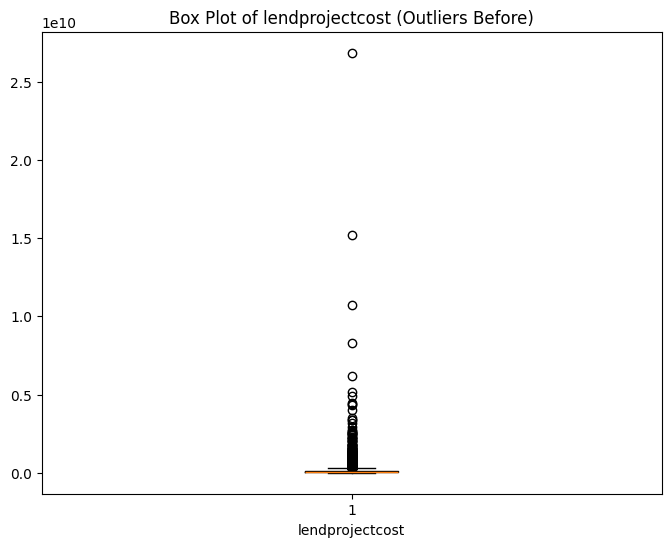

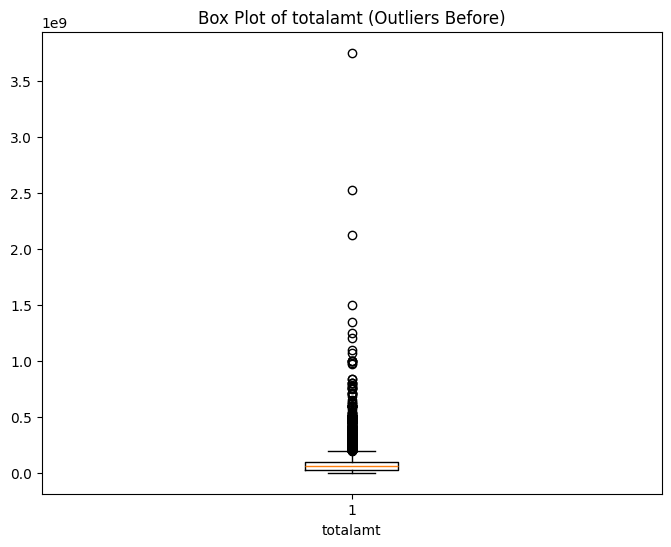

In [44]:
outlier_data = ds7['lendprojectcost']
plt.figure(figsize=(8, 6))
plt.boxplot(outlier_data)
plt.title('Box Plot of lendprojectcost (Outliers Before)')
plt.xlabel('lendprojectcost')
plt.show()

outlier_data = ds7['totalamt']
plt.figure(figsize=(8, 6))
plt.boxplot(outlier_data)
plt.title('Box Plot of totalamt (Outliers Before)')
plt.xlabel('totalamt')
plt.show()

##### 4.0.1.2 Visualisasi Setelah (AFTER)

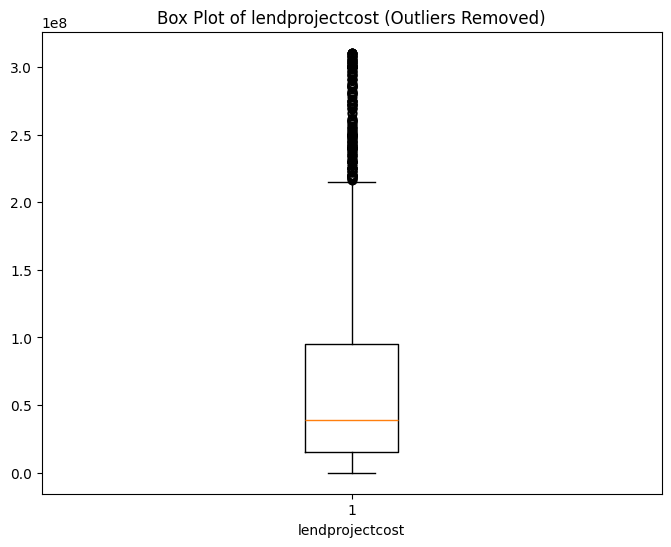

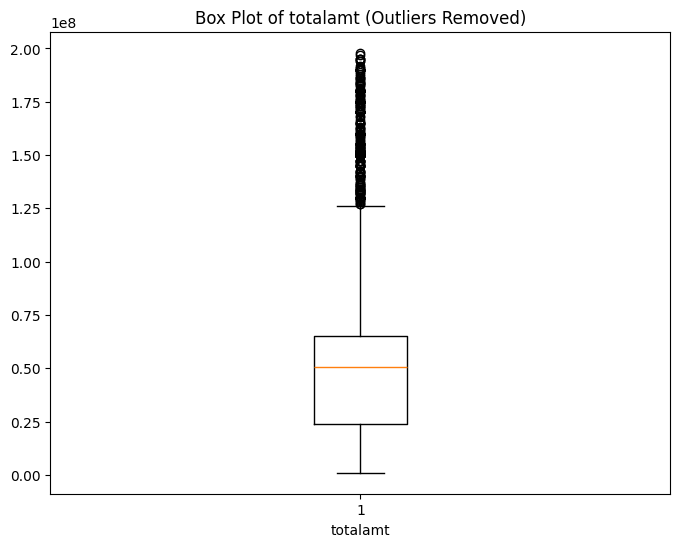

In [45]:
non_outlier_data_lendprojectcost = ds7[ds7['is_outlier_lendprojectcost'] == 0]['lendprojectcost']
plt.figure(figsize=(8, 6))
plt.boxplot(non_outlier_data_lendprojectcost)
plt.title('Box Plot of lendprojectcost (Outliers Removed)')
plt.xlabel('lendprojectcost')
plt.show()

non_outlier_data_totalamt = ds7['totalamt_non_outlier']
plt.figure(figsize=(8, 6))
plt.boxplot(non_outlier_data_totalamt)
plt.title('Box Plot of totalamt (Outliers Removed)')
plt.xlabel('totalamt')
plt.show()

#### 4.0.2 population_data.csv,json,xml,db, dan api (combined_ds)

In [46]:
# Menggabungkan kolom 1960 hingga 2017 menjadi satu list
# years_columns = [str(year) for year in range(1960, 2018)]
# year = combined_ds[years_columns].values.flatten()

# Menghitung outlier
# for year in range(1960,2018):
#     year_str = str(year)
#     Q1 = combined_ds[year_str].quantile(0.25)
#     Q3 = combined_ds[year_str].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_fence = Q1 - 1.5 * IQR
#     upper_fence = Q3 + 1.5 * IQR

#     combined_ds['is_outlier_combined_ds_'+year_str] = combined_ds[year_str].apply(
#         lambda x: 1 if (x < lower_fence) or (x > upper_fence) else 0
#     )

In [47]:
combined_ds_melt = pd.melt(combined_ds, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='Value')
# combined_ds_melt.to_csv('./result/combined_ds_melt.csv')
combined_ds_melt

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54211.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,8996351.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,1960,5643182.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1960,1608800.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,1960,13411.0
...,...,...,...,...,...,...
15249,Kosovo,XKX,"Population, total",SP.POP.TOTL,2017,1830700.0
15250,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,2017,28250420.0
15251,South Africa,ZAF,"Population, total",SP.POP.TOTL,2017,56717156.0
15252,Zambia,ZMB,"Population, total",SP.POP.TOTL,2017,17094130.0


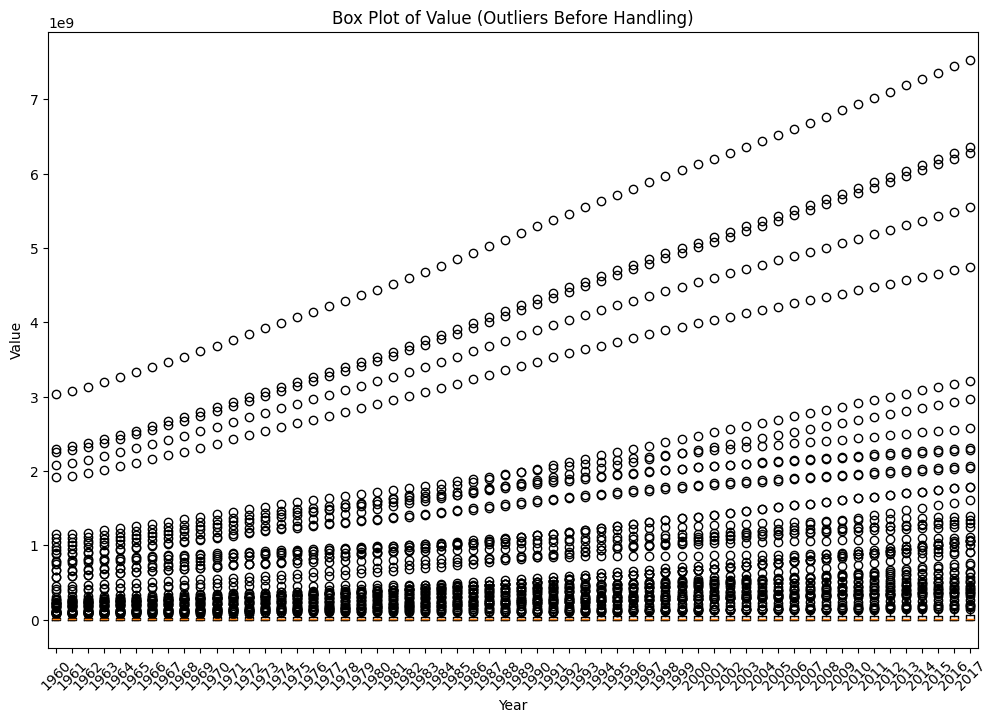

In [48]:
# Membuat box plot untuk semua tahun dalam satu plot
plt.figure(figsize=(12, 8))
plt.boxplot([combined_ds_melt[combined_ds_melt['Year'] == year]['Value'] for year in combined_ds_melt['Year'].unique()], labels=combined_ds_melt['Year'].unique())
plt.title('Box Plot of Value (Outliers Before Handling)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

### 4.1 Scaling Features pada dataset projects_data.csv, population_data.csv, population_data.json, population_data.xml, dan population_data.db. gunakan StandardScaler, MinMaxScaler, atau teknik lain untuk melakukan scaling pada dataset ini. contohnya pada fitur GDP atau population.

#### 4.1.1 projects_data.csv

In [49]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(ds7[['lendprojectcost']])
# Scaling data
scaled_df = pd.DataFrame(scaled_features, columns=['scaled_lendprojectcost'])

ds7['scaled_lendprojectcost'] = scaled_features
# ds7.to_csv('./result/projects_data_scaling.csv')

#### 4.1.2 hasil gabungan population_data csv,json,xml,db, dan api (combined_ds)

In [50]:
# Scaling data
scaler = StandardScaler()
# Ubah rentang tahun sesuai kebutuhan Anda
columns_to_scale = combined_ds.columns[combined_ds.columns.str.isnumeric()].tolist()
scaled_features = scaler.fit_transform(combined_ds[columns_to_scale])
scaled_df = pd.DataFrame(scaled_features, columns=[f'scaled_{col}' for col in columns_to_scale])

# Reset indeks DataFrame hasil scaling
scaled_df.reset_index(drop=True, inplace=True)

# Gabungkan hasil scaling dengan DataFrame asli
combined_ds = pd.concat([combined_ds, scaled_df], axis=1)

# Simpan hasil ke file CSV jika diperlukan
# combined_ds.to_csv('./result/combined_ds_scaling.csv', index=False)

#### 4.1.3 Hasil gabungan mystery, rural, electricity, dan gdp

In [51]:
# SCALING GDP COLUMNS
columns_to_scale = [col for col in comb.columns if col.endswith('_gdp') and comb[col].dtype != 'object']

# Scaling data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(comb[columns_to_scale])
scaled_df = pd.DataFrame(scaled_features, columns=[f'scaled_{col}' for col in columns_to_scale])

# Gabungkan hasil scaling dengan DataFrame asli
comb = pd.concat([comb, scaled_df], axis=1)

# Simpan hasil ke file CSV jika diperlukan
# comb.to_csv('./result/gdp_scaling.csv', index=False)

### 4.2 Feature Engineering

#### 4.2.1 projects_data.csv

In [52]:
ds7['budget_info'] = ds7.apply(lambda row: 'Over Budget' if row['lendprojectcost'] > row['totalamt'] else 'Within Budget', axis=1)
ds7.to_csv('./result/projects_data_final.csv')

#### 4.2.2 Gabungan population_data csv,json,xml,db, dan api (combined_ds)

In [53]:
# # Membuat kolom baru untuk menyimpan rata-rata pertumbuhan populasi
# combined_ds['avg_population_growth'] = 0.0

# Iterasi melalui setiap baris DataFrame
for index, row in combined_ds.iterrows():
    total_population = 0.0
    count = 0
    # Iterasi melalui kolom tahun 1960 sampai 2017
    for year in range(1960, 2018):
        population = row[str(year)]
        # Memastikan nilai populasi tidak kosong
        if (population != 0):
            total_population += population
            count += 1
    # Menghitung rata-rata pertumbuhan populasi dari tahun 1960 hingga 2017 untuk setiap baris
    if count > 0:
        avg_growth = total_population / count
        # Memperbarui nilai kolom 'avg_population_growth' untuk baris saat ini
        combined_ds.at[index, 'avg_population_growth'] = avg_growth

# Tampilkan DataFrame dengan kolom baru 'avg_population_growth'
combined_ds.to_csv('./result/combined_ds_final.csv')


#### 4.2.3 Gabungan mystery, rural, electricity, dan gdp (comb)

In [54]:
# Iterasi melalui tahun-tahun dari 1960 hingga 2017
for year in range(1960, 2018):
    # Buat nama kolom untuk GDP dan misteri pada tahun tertentu
    gdp_column = f'{year}_gdp'
    mystery_column = f'{year}_mystery'
    
    # Buat nama kolom baru untuk menyimpan hasil rasio GDP per kapita
    gdppercapita_column = f'{year}_gdppercapita'
    
    # Hitung rasio GDP per kapita dan simpan ke dalam kolom baru
    comb[gdppercapita_column] = comb[gdp_column] / comb[mystery_column]

comb.to_csv('./result/rem_gdp_final.csv')


## Load

In [55]:
# Menentukan kolom-kolom yang ingin dijadikan variabel-variabel
id_vars = ['Country Name', 'Country Code']
value_vars = {
    'gdp': 'gdp',
    'population': 'mystery',
    'gdppercapita': 'gdppercapita',
    'ruralpopulationpercent': 'rural_population_percent',
    'electricityaccesspercent': 'electricity_access_percent'
}

# Melt dataset untuk setiap kategori variabel
melted_datasets = {}
for year in range(1960, 2018):
    for category, column_suffix in value_vars.items():
        year_column = f'{year}_{column_suffix}'
        melted_data = pd.melt(comb, id_vars=id_vars, value_vars=[year_column], var_name='Year', value_name=category)
        melted_datasets.setdefault(category, []).append(melted_data)

# Gabungkan dataset yang telah dilelehkan menjadi satu dataset tunggal
load_datasets = None
for category, datasets in melted_datasets.items():
    category_data = pd.concat(datasets)
    if load_datasets is None:
        load_datasets = category_data
    else:
        load_datasets = pd.merge(load_datasets, category_data, on=['Country Name', 'Country Code', 'Year'], how='outer')

# Ubah format tahun menjadi hanya tahunnya saja
load_datasets['Year'] = load_datasets['Year'].str.split('_').str[0]
load_datasets = load_datasets.groupby(['Country Name', 'Country Code', 'Year']).first().reset_index()
load_datasets['Country Name'] = pd.Categorical(load_datasets['Country Name'], categories=load_datasets['Country Name'].unique(), ordered=True)
load_datasets['Country Code'] = pd.Categorical(load_datasets['Country Code'], categories=load_datasets['Country Code'].unique(), ordered=True)

# Urutkan DataFrame berdasarkan 'Country Name' dan 'Country Code'
load_dataset = load_datasets.sort_values(by=['Country Name', 'Country Code', 'Year'], ignore_index=True)

# Simpan hasil ke file CSV jika diperlukan
load_datasets.to_csv('./result/load_dataset.csv', index=False)

# Tampilkan hasil gabungan dataset
load_datasets


,Country Name,Country Code,Year,gdp,population,gdppercapita,ruralpopulationpercent,electricityaccesspercent
0,Afghanistan,AFG,1960,5.377778e+08,8996351.0,59.777327,91.779,0.000000
1,Afghanistan,AFG,1961,5.488889e+08,9166764.0,59.878153,91.492,0.000000
2,Afghanistan,AFG,1962,5.466667e+08,9345868.0,58.492874,91.195,0.000000
3,Afghanistan,AFG,1963,7.511112e+08,9533954.0,78.782758,90.890,0.000000
4,Afghanistan,AFG,1964,8.000000e+08,9731361.0,82.208444,90.574,0.000000
...,...,...,...,...,...,...,...,...
15249,Zimbabwe,ZWE,2013,1.545177e+10,15054506.0,1026.388292,67.346,37.076813
15250,Zimbabwe,ZWE,2014,1.589105e+10,15411675.0,1031.104614,67.499,32.300000
15251,Zimbabwe,ZWE,2015,1.630467e+10,15777451.0,1033.415841,67.624,33.700000
15252,Zimbabwe,ZWE,2016,1.661996e+10,16150362.0,1029.076649,67.723,38.145138


#### Proses Load ke Supabase

In [56]:
load_dotenv()

url = os.environ["SUPABASE_URL"]
key = os.environ["SUPABASE_KEY"]
supabase = create_client(url, key)

# with open("./result/load_dataset.csv", "rb") as f:
#     supabase.storage.from_("alterra-bucket").upload(
#         file=f,
#         path="load_dataset.csv"
#     )

# Daftar file yang ingin diunggah
file_paths = ["./result/load_dataset.csv", "./result/projects_data_final.csv", "./result/combined_ds_final.csv", "./result/rem_gdp_final.csv"]

# Unggah setiap file ke penyimpanan Supabase
for file_path in file_paths:
    with open(file_path, "rb") as f:
        supabase.storage.from_("alterra-bucket").upload(
            file=f,
            path=os.path.basename(file_path)
        )

#### Proses Load ke AWS Amazon Web Service

In [57]:
load_dotenv()

aws_access_key = os.environ["AWS_ACCESS_KEY_ID"]
aws_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]

# Nama bucket yang ingin Anda buat
bucket_name = 'alterra-mini-project'

# Inisialisasi koneksi S3 dengan menentukan wilayah
s3 = boto3.client('s3',
                  aws_access_key_id=aws_access_key,
                  aws_secret_access_key=aws_secret_key
                  )

# Membuat bucket jika belum ada
# s3.create_bucket(Bucket=bucket_name)

# List File untuk diupload
file_uploads = ['projects_data_final.csv', 'combined_ds_final.csv', 'rem_gdp_final.csv', 'load_dataset.csv']

# Lokasi file lokal yang ingin diunggah
folder_path = './result'

# Loop melalui setiap file yang ingin Anda unggah
for file_name in file_uploads:
    # Lokasi file lokal
    local_file_path = os.path.join(folder_path, file_name)
    
    # Nama file di S3
    s3_file_key = file_name
    
    # Melakukan pengunggahan file ke S3
    s3.upload_file(local_file_path, bucket_name, s3_file_key)

    print(f"File {local_file_path} telah diunggah ke bucket {bucket_name} dengan nama {s3_file_key}.")

File ./result\projects_data_final.csv telah diunggah ke bucket alterra-mini-project dengan nama projects_data_final.csv.
File ./result\combined_ds_final.csv telah diunggah ke bucket alterra-mini-project dengan nama combined_ds_final.csv.
File ./result\rem_gdp_final.csv telah diunggah ke bucket alterra-mini-project dengan nama rem_gdp_final.csv.
File ./result\load_dataset.csv telah diunggah ke bucket alterra-mini-project dengan nama load_dataset.csv.


#### Random Character Generator

In [58]:
def generate_random_app_name(length):
    """Generate a random app name."""
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for _ in range(length))

#### Proses Load ke Google Cloud (Firebase)

In [59]:
# Memuat nilai dari file .env
load_dotenv()

# Mengambil nilai dari variabel yang didefinisikan di .env
storageBucket = os.getenv("GOOGLE_STORAGE_BUCKET")
certPath = os.getenv("CERTIFICATE_PATH")

# Inisialisasi Firebase
cred = credentials.Certificate(certPath)
uniq_name = generate_random_app_name(10)
app_name = uniq_name  # Memberikan nama unik untuk aplikasi Firebase
firebase_app = initialize_app(cred, {"storageBucket": storageBucket}, name=app_name)
files_to_upload = ["./result/load_dataset.csv", "./result/projects_data_final.csv", "./result/combined_ds_final.csv", "./result/rem_gdp_final.csv"]

# Mengunggah setiap file ke Firebase Cloud Storage
for filename in files_to_upload:
    bucket = storage.bucket(app=firebase_app)  # Menggunakan objek firebase_admin.App sebagai argumen
    blob = bucket.blob(blob_name=os.path.basename(filename))  # Menggunakan nama file sebagai nama blob
    blob.upload_from_filename(filename)
    print(f"{filename} uploaded successfully")

./result/load_dataset.csv uploaded successfully
./result/projects_data_final.csv uploaded successfully
./result/combined_ds_final.csv uploaded successfully
./result/rem_gdp_final.csv uploaded successfully


## Visualisasi Data

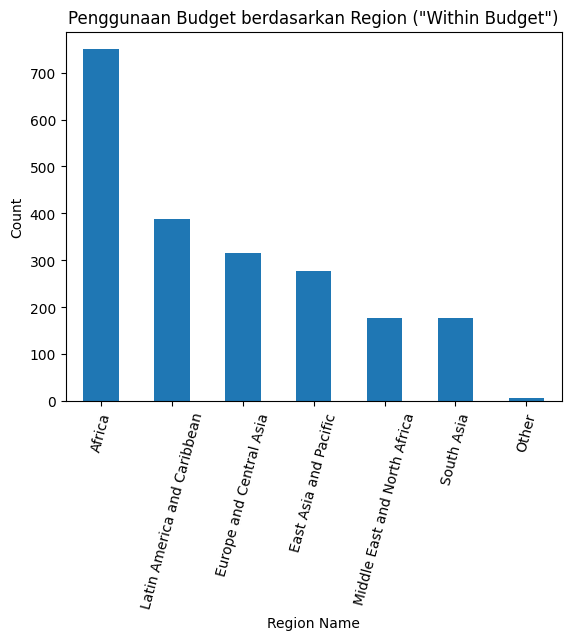

In [60]:
reg_within_budget = ds7[ds7['budget_info'] == 'Within Budget'][['regionname', 'budget_info']]
# Menghitung jumlah kemunculan 'regionname' yang memiliki 'budget_info' 'Within Budget'
region_counts = reg_within_budget['regionname'].value_counts()

# Plotting diagram batang
region_counts.plot(kind='bar')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Region Name')
plt.ylabel('Count')
plt.xticks(rotation=75)

# Menambahkan judul
plt.title('Penggunaan Budget berdasarkan Region ("Within Budget")')

# Menampilkan diagram
plt.show()

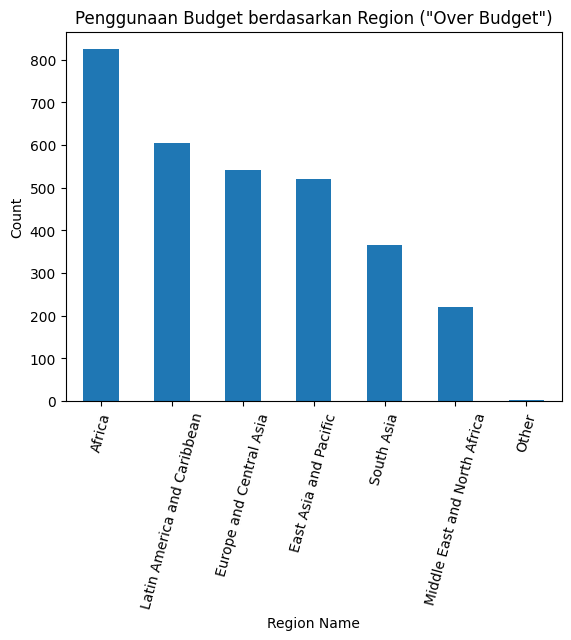

In [61]:
reg_over_budget = ds7[ds7['budget_info'] == 'Over Budget'][['regionname', 'budget_info']]
# Menghitung jumlah kemunculan 'regionname' yang memiliki 'budget_info' 'over Budget'
region_counts = reg_over_budget['regionname'].value_counts()

# Plotting diagram batang
region_counts.plot(kind='bar')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Region Name')
plt.ylabel('Count')
plt.xticks(rotation=75)

# Menambahkan judul
plt.title('Penggunaan Budget berdasarkan Region ("Over Budget")')

# Menampilkan diagram
plt.show()

C:\Users\muham\AppData\Local\Temp\ipykernel_27996\3612924582.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


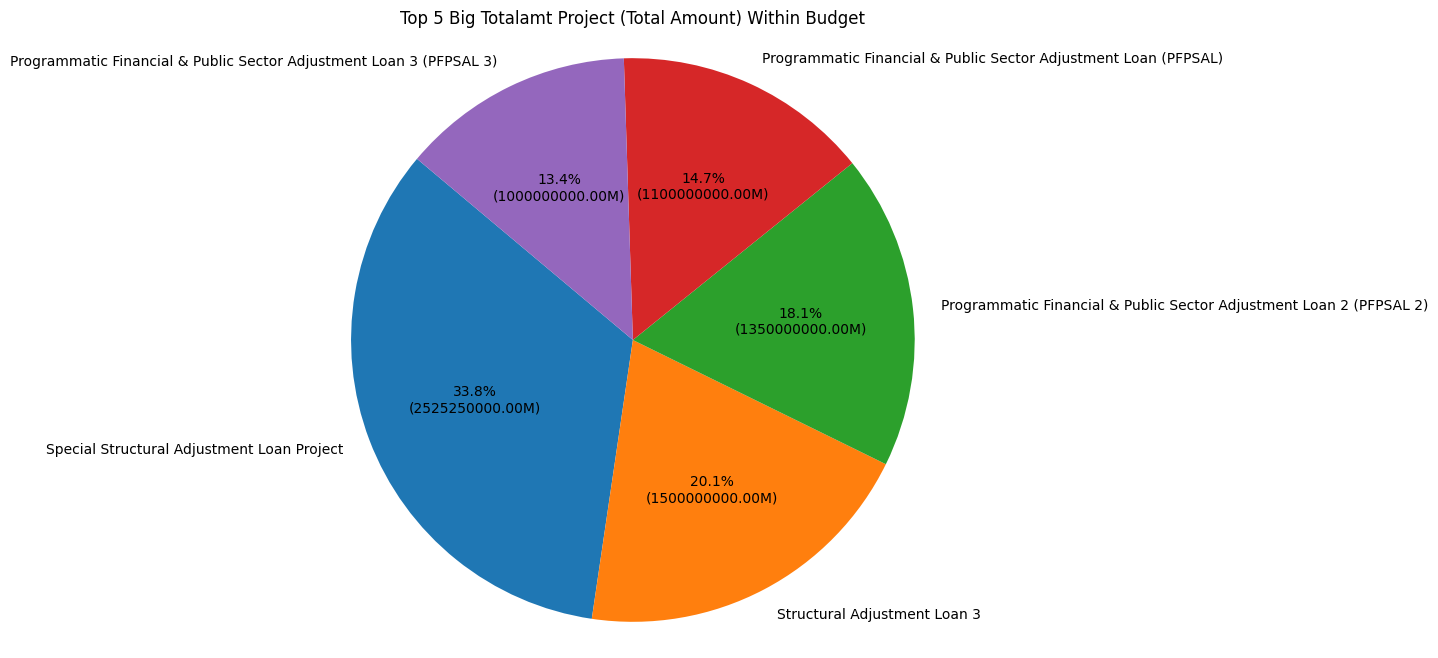

In [62]:
# Filter data untuk budget_info = "within budget"
within_budget_data = ds7[ds7['budget_info'] == 'Within Budget']

# Urutkan entri berdasarkan totalamt secara menurun
sorted_within_budget_data = within_budget_data.sort_values(by='totalamt', ascending=False)

# Pilih 5 entri teratas
top_5_projects = sorted_within_budget_data.head(5)

# Menghitung total totalamt dari 5 proyek teratas
total_totalamt = top_5_projects['totalamt'].sum()

# Membuat plot pie untuk memvisualisasikan totalamt dari setiap proyek
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(top_5_projects['totalamt'], labels=top_5_projects['project_name'], startangle=140, autopct='%1.1f%%')

# Menambahkan informasi totalamt di bawah persentase
for i, (autotext, text) in enumerate(zip(autotexts, top_5_projects['totalamt'])):
    autotext.set_text(f'{autotext.get_text()}\n({text:.2f}M)')

# Menambahkan judul plot
plt.title('Top 5 Big Totalamt Project (Total Amount) Within Budget')
plt.axis('equal')  # Memastikan lingkaran berbentuk bulat
plt.tight_layout()
plt.show()

C:\Users\muham\AppData\Local\Temp\ipykernel_27996\915188707.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


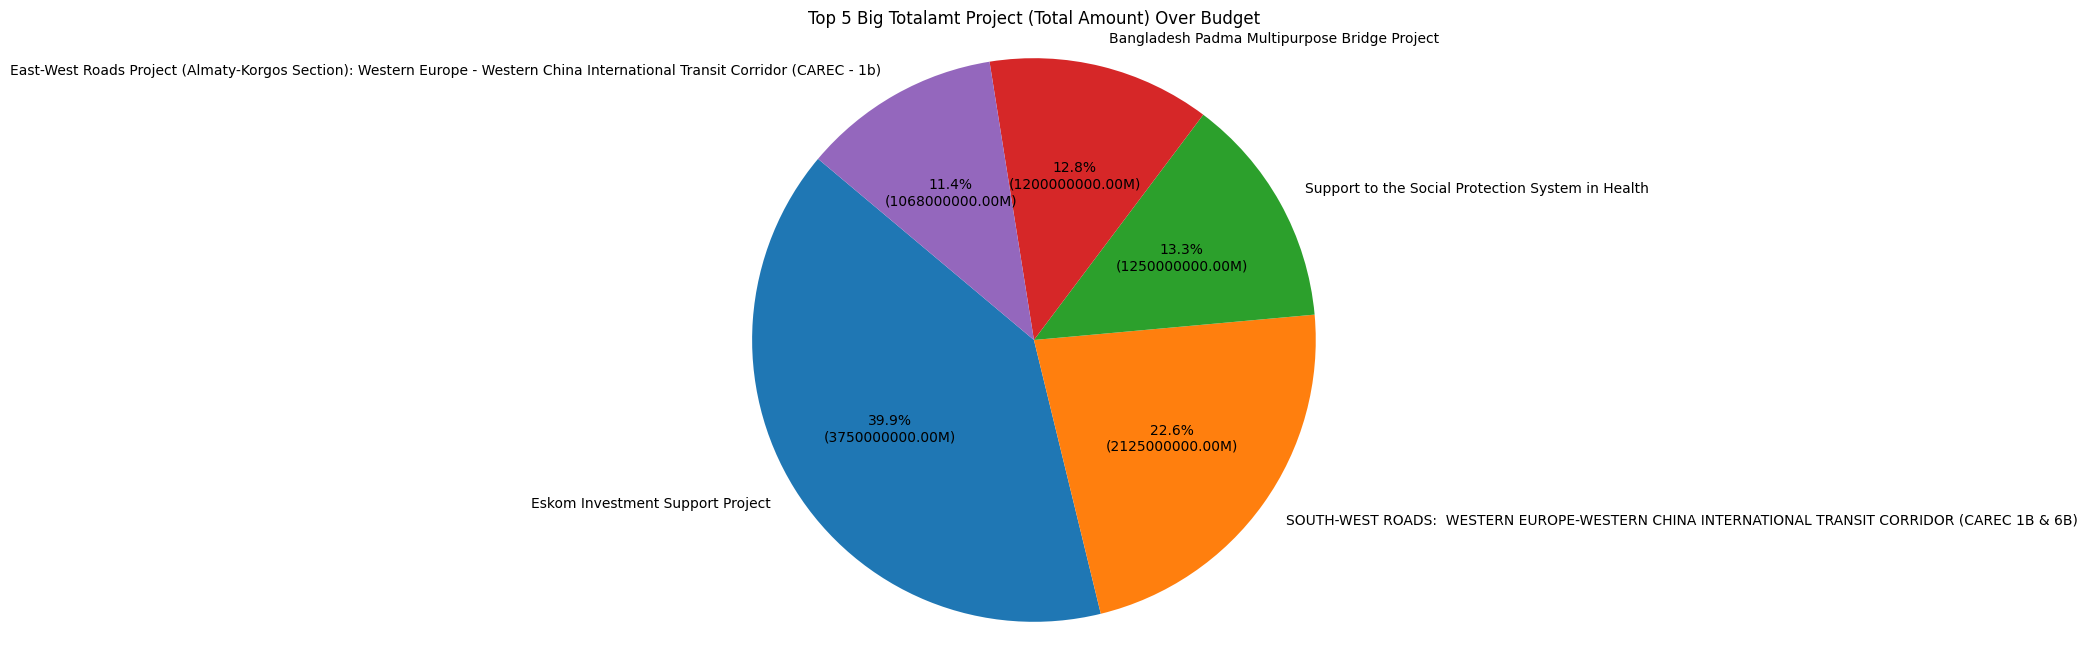

In [63]:
within_budget_data = ds7[ds7['budget_info'] == 'Over Budget']

# Urutkan entri berdasarkan totalamt secara menurun
sorted_within_budget_data = within_budget_data.sort_values(by='totalamt', ascending=False)

# Pilih 5 entri teratas
top_5_projects = sorted_within_budget_data.head(5)

# Menghitung total totalamt dari 5 proyek teratas
total_totalamt = top_5_projects['totalamt'].sum()

# Membuat plot pie untuk memvisualisasikan totalamt dari setiap proyek
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(top_5_projects['totalamt'], labels=top_5_projects['project_name'], startangle=140, autopct='%1.1f%%')

# Menambahkan informasi totalamt di bawah persentase
for i, (autotext, text) in enumerate(zip(autotexts, top_5_projects['totalamt'])):
    autotext.set_text(f'{autotext.get_text()}\n({text:.2f}M)')

# Menambahkan judul plot
plt.title('Top 5 Big Totalamt Project (Total Amount) Over Budget')
plt.axis('equal')  # Memastikan lingkaran berbentuk bulat
plt.tight_layout()
plt.show()

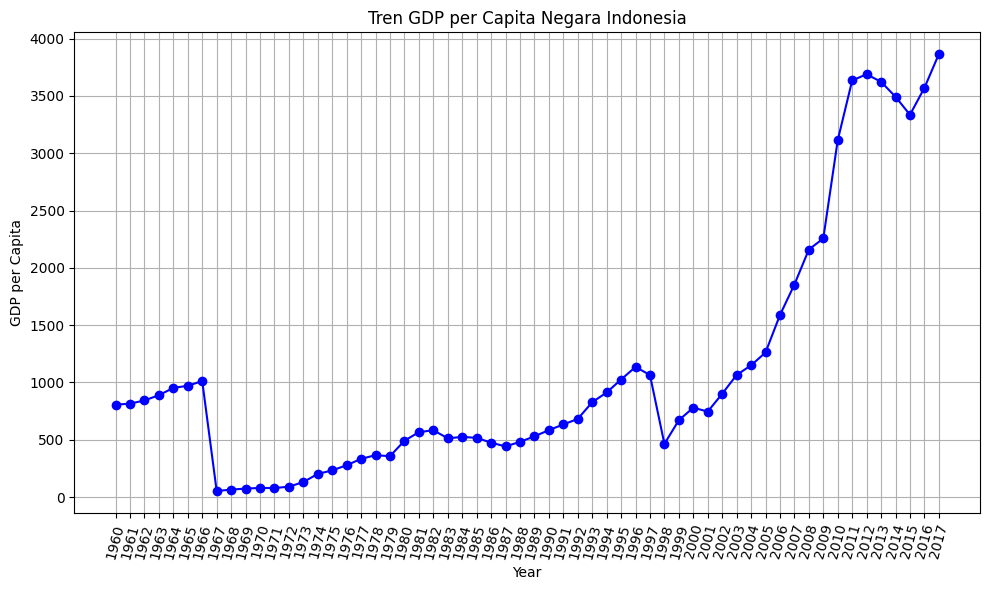

In [64]:
country_name = 'Indonesia'
data_country = load_datasets[load_datasets['Country Name'] == country_name]

# plot tren GDP per capita
plt.figure(figsize=(10, 6))
plt.plot(data_country['Year'], data_country['gdppercapita'], marker='o', color='b', linestyle='-')

# label sumbu x dan y, serta judul plot
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.title('Tren GDP per Capita Negara Indonesia')
plt.xticks(rotation=75)
# show plot
plt.grid(True)
plt.tight_layout()
plt.show()

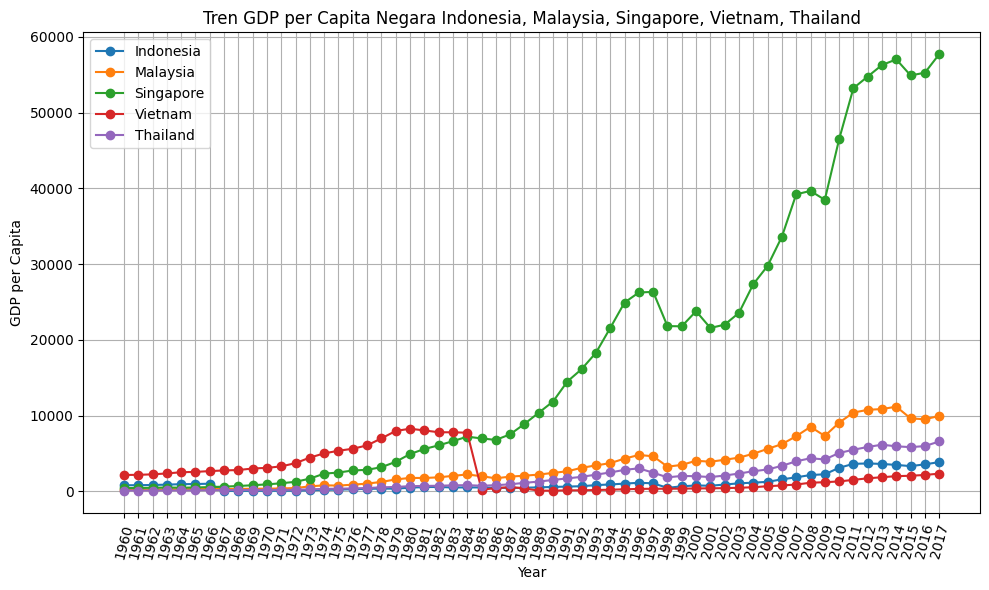

In [65]:
countries = ['Indonesia', 'Malaysia', 'Singapore', 'Vietnam', 'Thailand']

# plot tren GDP per capita untuk setiap negara dalam satu loop
plt.figure(figsize=(10, 6))
for country_name in countries:
    data_country = load_datasets[load_datasets['Country Name'] == country_name]
    plt.plot(data_country['Year'], data_country['gdppercapita'], marker='o', linestyle='-', label=country_name)

# label sumbu x dan y, serta judul plot
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.title('Tren GDP per Capita Negara {}'.format(', '.join(countries)))
plt.xticks(rotation=75)
plt.legend()

# show plot
plt.grid(True)
plt.tight_layout()
plt.show()


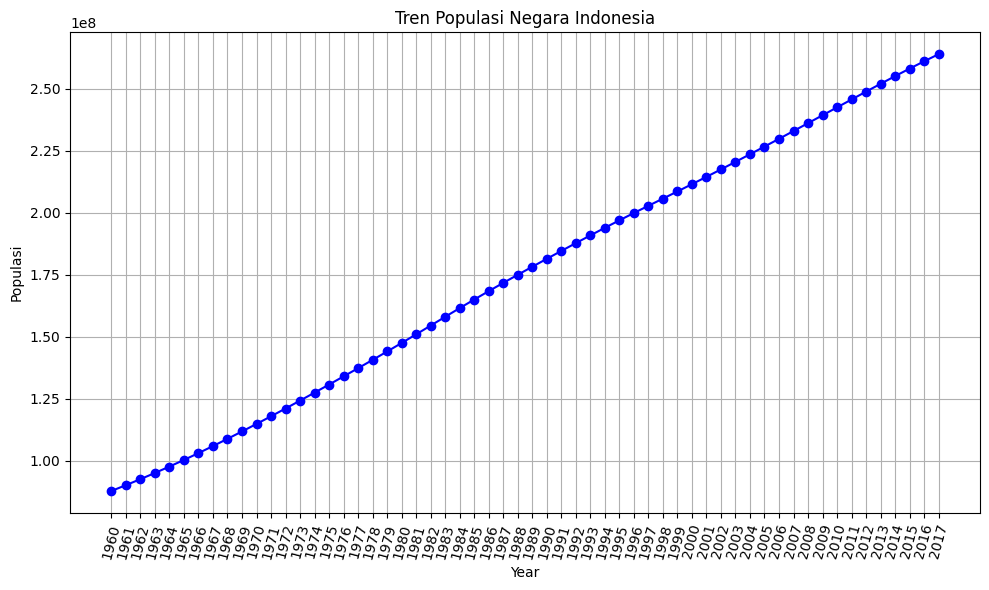

In [69]:
country_name = 'Indonesia'
data_country = load_datasets[load_datasets['Country Name'] == country_name]

# plot tren GDP per capita
plt.figure(figsize=(10, 6))
plt.plot(data_country['Year'], data_country['population'], marker='o', color='b', linestyle='-')

# label sumbu x dan y, serta judul plot
plt.xlabel('Year')
plt.ylabel('Populasi')
plt.title('Tren Populasi Negara Indonesia')
plt.xticks(rotation=75)
# show plot
plt.grid(True)
plt.tight_layout()
plt.show()

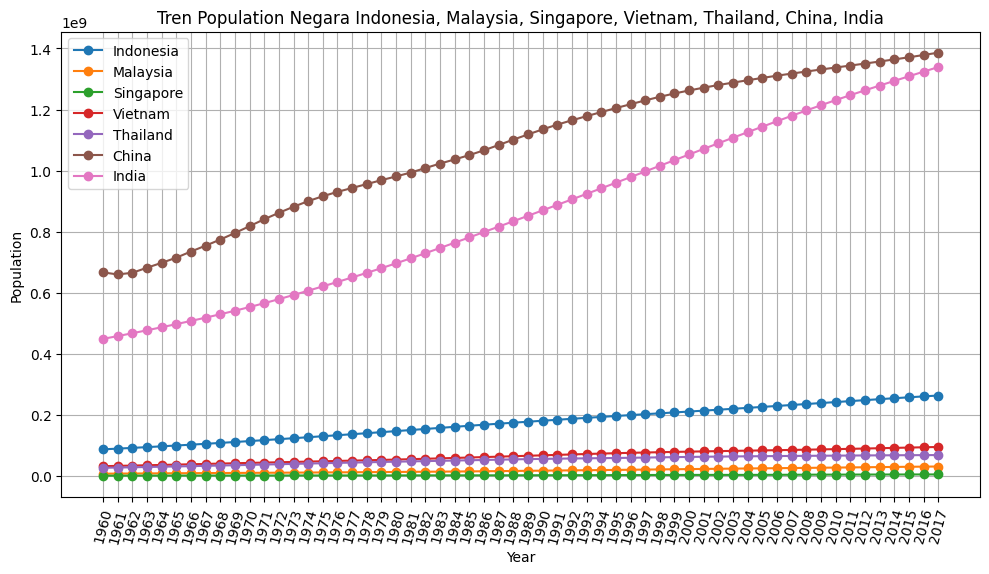

In [66]:
# List negara-negara yang ingin Anda plot
countries = ['Indonesia', 'Malaysia', 'Singapore', 'Vietnam', 'Thailand', 'China', 'India']

# Membuat plot tren GDP per capita untuk setiap negara dalam satu loop
plt.figure(figsize=(10, 6))
for country_name in countries:
    data_country = load_datasets[load_datasets['Country Name'] == country_name]
    plt.plot(data_country['Year'], data_country['population'], marker='o', linestyle='-', label=country_name)

# Menambahkan label sumbu x dan y, serta judul plot
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Tren Population Negara {}'.format(', '.join(countries)))
plt.xticks(rotation=75)

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.grid(True)
plt.tight_layout()
plt.show()


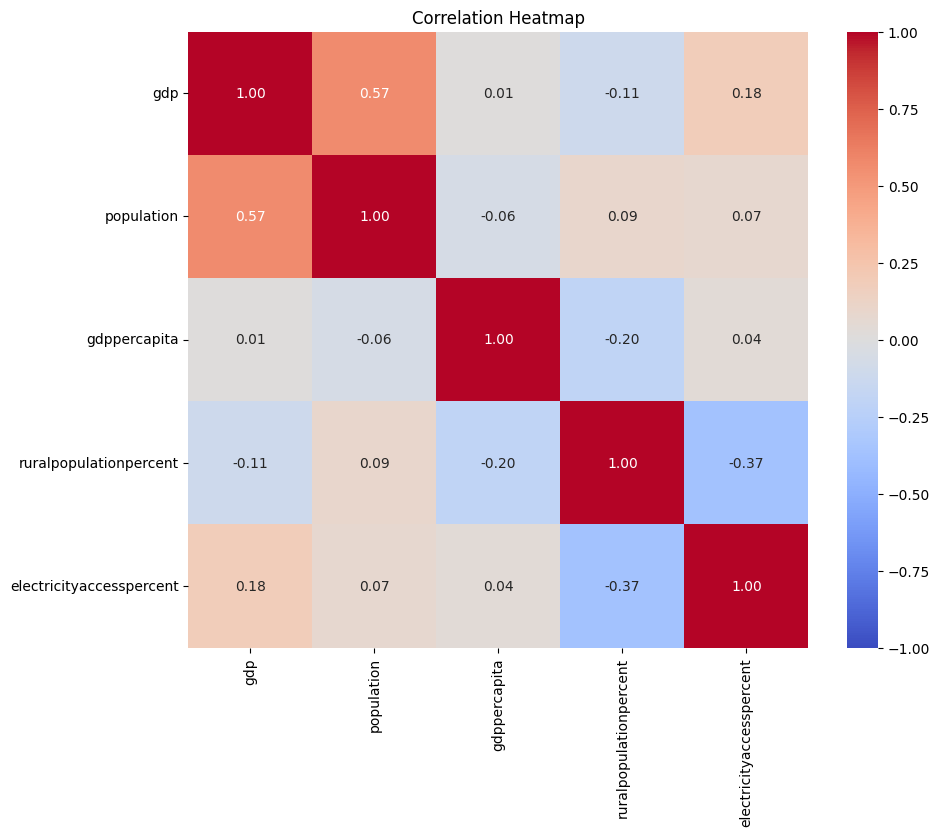

In [67]:
# Pilih hanya kolom-kolom numerik
numeric_columns = load_datasets.select_dtypes(include=['int64', 'float64'])

# Hitung matriks korelasi
correlation_matrix = numeric_columns.corr()

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()
